# NBA Dataset - Sistemas Basados en el Conocimiento

In [2]:
#Librerías

import numpy as np
import pandas as pd
import seaborn as sns
import pydot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image
from six import StringIO
from sklearn.metrics import roc_auc_score
from IPython.display import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
import time

In [3]:
#Carga de Datos
nba_data = pd.read_csv("all_seasons.csv")
nba_data.head()

Unnamed: 0       player_name team_abbreviation   age  player_height  \
0           0  Randy Livingston               HOU  22.0         193.04   
1           1  Gaylon Nickerson               WAS  28.0         190.50   
2           2      George Lynch               VAN  26.0         203.20   
3           3    George McCloud               LAL  30.0         203.20   
4           4      George Zidek               DEN  23.0         213.36   

   player_weight                college country draft_year draft_round  ...  \
0      94.800728        Louisiana State     USA       1996           2  ...   
1      86.182480  Northwestern Oklahoma     USA       1994           2  ...   
2     103.418976         North Carolina     USA       1993           1  ...   
3     102.058200          Florida State     USA       1989           1  ...   
4     119.748288                   UCLA     USA       1995           1  ...   

    pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0   3.9  1.5  2.4         0.3     0.042     0.071    0.169   0.487    0.248   
1   3.8  1.3  0.3         8.9     0.030     0.111    0.174   0.497    0.043   
2   8.3  6.4  1.9        -8.2     0.106     0.185    0.175   0.512    0.125   
3  10.2  2.8  1.7        -2.7     0.027     0.111    0.206   0.527    0.125   
4   2.8  1.7  0.3       -14.1     0.102     0.169    0.195   0.500    0.064   

    season  
0  1996-97  
1  1996-97  
2  1996-97  
3  1996-97  
4  1996-97  

[5 rows x 22 columns]

# Procesado Inicial

Para empezar, vamos a dedicarnos a tratar los datos. Antes de todo querremos limpiarlos, solucionando así problemas que pueden surgir en función del tipo de datos que tengamos o de como estén distribuidos y luego nos encargaremos de explorarlos y entenderlos mejor para ver que es lo más interesante a explorar.

In [4]:
#Valores nulos nba_data
count_null = nba_data.isnull().sum()
print(count_null)

Unnamed: 0              0
player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college              1854
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
dtype: int64


**Valores Nulos**

Para empezar, vamos a eliminar las columnas categóricas que no aportan demasiada información. Una de ellas es college, que tiene bastantes valores nulos:

Esto se debe a que no todos los jugadores que llegan a la NBA tienen un previo paso por universidades, de hecho, la mayoría de los no americanos, llegan a la liga desde ligas profesionales y sin previo paso por la universidad. Ahora empieza a darse la situación que también jugadores americanos no van a la universidad y juegan en una liga semiprofesional americana llamada NBA G League Ignite, donde forman a jóvenes talentos. Además, la normativa sobre la edad mínima ha ido cambiando, Kobe Bryant fue directamente desde el instituto a la NBA porque en su época estaba permitido. Otro ejemplo de jugador que no ha pasado por la universidad es Luka Doncic, de los mejores jugadores de la liga y que viene directamente del Real Madrid.

Sabiendo esto, y teniendo en cuenta que lo último que queremos hacer es eliminar jugadores que pueden tener mucho valor, creo que lo que tiene más sentido es eliminar la columna de college.

**Otras variables Categóricas**

Luego tenemos la variable name, que no nos hará falta, de momento, no queremos analizar las estadísticas de ningún jugador en concreto y, por otro lado, la variable 'country'. El país tampoco nos dará demasiada información de cara al estudio que queremos hacer, y menos, viendo como nos dan los datos de país, siendo todos de tipo texto. Años atrás la NBA era una liga principalmente americana, donde los internacionales eran 'rara avis' pero vamos a analizar sobre todo datos de los últimos años donde la cantidad de jugadores internacionales ha aumentado muchísimo y su importancia en la liga también, 4 de los últimos 5 MVPs no son americanos. Así que, bajo mi punto de vista, no tiene demasiado sentido tener en cuenta esta información.

Tampoco hace falta la variable unnamed, que son etiquetas numéricas de cada jugador que no aportan información.

Por último, tenemos el 'team_abbreviation', que nos da información sobre el equipo en el que juega ese jugador. Siempre se dice que la NBA es una de las ligas más igualadas del mundo gracias a su sistema de draft, los últimos, reciben a los mejores jugadores jóvenes, y de esta manera se busca equilibrar la liga, así que creo que a la larga tus estadísticas de juego no deberían depender en exceso de en que equipo juegues.

In [5]:
delete = ['player_name','college', 'country','team_abbreviation','Unnamed: 0']
nba_clean = nba_data.drop(columns = delete)
nba_clean.head()

age  player_height  player_weight draft_year draft_round draft_number  gp  \
0  22.0         193.04      94.800728       1996           2           42  64   
1  28.0         190.50      86.182480       1994           2           34   4   
2  26.0         203.20     103.418976       1993           1           12  41   
3  30.0         203.20     102.058200       1989           1            7  64   
4  23.0         213.36     119.748288       1995           1           22  52   

    pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0   3.9  1.5  2.4         0.3     0.042     0.071    0.169   0.487    0.248   
1   3.8  1.3  0.3         8.9     0.030     0.111    0.174   0.497    0.043   
2   8.3  6.4  1.9        -8.2     0.106     0.185    0.175   0.512    0.125   
3  10.2  2.8  1.7        -2.7     0.027     0.111    0.206   0.527    0.125   
4   2.8  1.7  0.3       -14.1     0.102     0.169    0.195   0.500    0.064   

    season  
0  1996-97  
1  1996-97  
2  1996-97  
3  1996-97  
4  1996-97

También hará falta tratar los datos de las columnas 'draft_year', 'draft_round', 'draft_number' y 'season', ya que en las 3 primeras existen datos de tipo texto y en la última tenemos las temporadas también con un carácter que nos puede traer problemas (-).

Empezando con los datos de la columna season, lo que haremos es transformarlos a 'integers' después de eliminar todos excepto los últimos tres caracteres. De esta manera nos quedará el año en el que la temporada acabó, y tendremos que ser conscientes de ello cuando analicemos los datos.

La temporada 2020-21 ahora es la temporada 21.

In [6]:
nba_clean['season'] = nba_clean['season'].str[-2:].astype(int)
nba_clean.head()

age  player_height  player_weight draft_year draft_round draft_number  gp  \
0  22.0         193.04      94.800728       1996           2           42  64   
1  28.0         190.50      86.182480       1994           2           34   4   
2  26.0         203.20     103.418976       1993           1           12  41   
3  30.0         203.20     102.058200       1989           1            7  64   
4  23.0         213.36     119.748288       1995           1           22  52   

    pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0   3.9  1.5  2.4         0.3     0.042     0.071    0.169   0.487    0.248   
1   3.8  1.3  0.3         8.9     0.030     0.111    0.174   0.497    0.043   
2   8.3  6.4  1.9        -8.2     0.106     0.185    0.175   0.512    0.125   
3  10.2  2.8  1.7        -2.7     0.027     0.111    0.206   0.527    0.125   
4   2.8  1.7  0.3       -14.1     0.102     0.169    0.195   0.500    0.064   

   season  
0      97  
1      97  
2      97  
3      97  
4      97

Analizando los datos de los undrafted, vemos que aunque los años tienen algunos valores, tanto la ronda como los números son todos iguales, y tenemos, 2414 valores.

Visto esto, vamos a tratar a todos los jugadores que no han sido drafteados como jugadores que son de tercera ronda (en la NBA, el draft solo tiene dos rondas) y vamos a decir que su número del draft va a ser igual a 61 (cada ronda tiene 30 jugadores, es decir, cada año el draft lo forman 60), de esta manera les asignaremos un valor numérico que los colocará por debajo de los que si han sido drafteados y no hará diferencia entre ellos.

In [7]:
nba_clean[nba_clean['draft_number'] == 'Undrafted']

age  player_height  player_weight draft_year draft_round draft_number  \
25     29.0         193.04      86.182480       1992   Undrafted    Undrafted   
29     28.0         195.58      87.996848  Undrafted   Undrafted    Undrafted   
39     23.0         190.50      95.254320  Undrafted   Undrafted    Undrafted   
41     27.0         200.66     106.594120  Undrafted   Undrafted    Undrafted   
46     31.0         203.20      99.790240  Undrafted   Undrafted    Undrafted   
...     ...            ...            ...        ...         ...          ...   
12831  25.0         215.90     108.862080  Undrafted   Undrafted    Undrafted   
12835  27.0         210.82     115.665960  Undrafted   Undrafted    Undrafted   
12837  35.0         205.74      99.790240  Undrafted   Undrafted    Undrafted   
12840  20.0         213.36      86.182480  Undrafted   Undrafted    Undrafted   
12843  33.0         205.74     102.965384  Undrafted   Undrafted    Undrafted   

       gp   pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
25     71   5.7  1.6  1.3        -0.3     0.036     0.076    0.172   0.539   
29     13   5.0  1.7  2.0         6.6     0.011     0.098    0.144   0.565   
39     28  10.6  3.2  2.4        -6.4     0.032     0.112    0.216   0.510   
41      5   2.6  0.6  0.4        17.5     0.026     0.049    0.192   0.388   
46     53   6.7  1.5  0.4         1.2     0.034     0.067    0.171   0.555   
...    ..   ...  ...  ...         ...       ...       ...      ...     ...   
12831   7   7.3  3.0  1.4        -1.1     0.060     0.153    0.155   0.796   
12835  69   6.6  4.1  1.0         7.9     0.114     0.164    0.182   0.595   
12837  46   6.9  2.8  3.3         2.5     0.012     0.102    0.122   0.616   
12840  19   2.4  0.9  0.6       -16.1     0.012     0.065    0.102   0.411   
12843  57   6.4  3.6  0.9        -8.2     0.087     0.164    0.169   0.650   

       ast_pct  season  
25       0.141      97  
29       0.191      97  
39       0.161      97  
41       0.065      97  
46       0.036      97  
...        ...     ...  
12831    0.135      23  
12835    0.101      23  
12837    0.181      23  
12840    0.066      23  
12843    0.094      23  

[2414 rows x 17 columns]

In [8]:
nba_clean[nba_clean['draft_year'] == 'Undrafted']

age  player_height  player_weight draft_year draft_round draft_number  \
29     28.0         195.58      87.996848  Undrafted   Undrafted    Undrafted   
39     23.0         190.50      95.254320  Undrafted   Undrafted    Undrafted   
41     27.0         200.66     106.594120  Undrafted   Undrafted    Undrafted   
46     31.0         203.20      99.790240  Undrafted   Undrafted    Undrafted   
54     27.0         208.28     120.201880  Undrafted   Undrafted    Undrafted   
...     ...            ...            ...        ...         ...          ...   
12831  25.0         215.90     108.862080  Undrafted   Undrafted    Undrafted   
12835  27.0         210.82     115.665960  Undrafted   Undrafted    Undrafted   
12837  35.0         205.74      99.790240  Undrafted   Undrafted    Undrafted   
12840  20.0         213.36      86.182480  Undrafted   Undrafted    Undrafted   
12843  33.0         205.74     102.965384  Undrafted   Undrafted    Undrafted   

       gp   pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
29     13   5.0  1.7  2.0         6.6     0.011     0.098    0.144   0.565   
39     28  10.6  3.2  2.4        -6.4     0.032     0.112    0.216   0.510   
41      5   2.6  0.6  0.4        17.5     0.026     0.049    0.192   0.388   
46     53   6.7  1.5  0.4         1.2     0.034     0.067    0.171   0.555   
54      4   1.3  1.0  0.0       -17.7     0.000     0.211    0.103   0.727   
...    ..   ...  ...  ...         ...       ...       ...      ...     ...   
12831   7   7.3  3.0  1.4        -1.1     0.060     0.153    0.155   0.796   
12835  69   6.6  4.1  1.0         7.9     0.114     0.164    0.182   0.595   
12837  46   6.9  2.8  3.3         2.5     0.012     0.102    0.122   0.616   
12840  19   2.4  0.9  0.6       -16.1     0.012     0.065    0.102   0.411   
12843  57   6.4  3.6  0.9        -8.2     0.087     0.164    0.169   0.650   

       ast_pct  season  
29       0.191      97  
39       0.161      97  
41       0.065      97  
46       0.036      97  
54       0.000      97  
...        ...     ...  
12831    0.135      23  
12835    0.101      23  
12837    0.181      23  
12840    0.066      23  
12843    0.094      23  

[2358 rows x 17 columns]

In [9]:
nba_clean[nba_clean['draft_round'] == 'Undrafted']

age  player_height  player_weight draft_year draft_round draft_number  \
25     29.0         193.04      86.182480       1992   Undrafted    Undrafted   
29     28.0         195.58      87.996848  Undrafted   Undrafted    Undrafted   
39     23.0         190.50      95.254320  Undrafted   Undrafted    Undrafted   
41     27.0         200.66     106.594120  Undrafted   Undrafted    Undrafted   
46     31.0         203.20      99.790240  Undrafted   Undrafted    Undrafted   
...     ...            ...            ...        ...         ...          ...   
12831  25.0         215.90     108.862080  Undrafted   Undrafted    Undrafted   
12835  27.0         210.82     115.665960  Undrafted   Undrafted    Undrafted   
12837  35.0         205.74      99.790240  Undrafted   Undrafted    Undrafted   
12840  20.0         213.36      86.182480  Undrafted   Undrafted    Undrafted   
12843  33.0         205.74     102.965384  Undrafted   Undrafted    Undrafted   

       gp   pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
25     71   5.7  1.6  1.3        -0.3     0.036     0.076    0.172   0.539   
29     13   5.0  1.7  2.0         6.6     0.011     0.098    0.144   0.565   
39     28  10.6  3.2  2.4        -6.4     0.032     0.112    0.216   0.510   
41      5   2.6  0.6  0.4        17.5     0.026     0.049    0.192   0.388   
46     53   6.7  1.5  0.4         1.2     0.034     0.067    0.171   0.555   
...    ..   ...  ...  ...         ...       ...       ...      ...     ...   
12831   7   7.3  3.0  1.4        -1.1     0.060     0.153    0.155   0.796   
12835  69   6.6  4.1  1.0         7.9     0.114     0.164    0.182   0.595   
12837  46   6.9  2.8  3.3         2.5     0.012     0.102    0.122   0.616   
12840  19   2.4  0.9  0.6       -16.1     0.012     0.065    0.102   0.411   
12843  57   6.4  3.6  0.9        -8.2     0.087     0.164    0.169   0.650   

       ast_pct  season  
25       0.141      97  
29       0.191      97  
39       0.161      97  
41       0.065      97  
46       0.036      97  
...        ...     ...  
12831    0.135      23  
12835    0.101      23  
12837    0.181      23  
12840    0.066      23  
12843    0.094      23  

[2411 rows x 17 columns]

In [10]:
nba_clean['draft_round'].replace('Undrafted', 3, inplace = True)
nba_clean['draft_number'].replace('Undrafted', 61, inplace = True)
nba_clean[nba_clean['draft_number'] == 61]

age  player_height  player_weight draft_year draft_round draft_number  \
25     29.0         193.04      86.182480       1992           3           61   
29     28.0         195.58      87.996848  Undrafted           3           61   
39     23.0         190.50      95.254320  Undrafted           3           61   
41     27.0         200.66     106.594120  Undrafted           3           61   
46     31.0         203.20      99.790240  Undrafted           3           61   
...     ...            ...            ...        ...         ...          ...   
12831  25.0         215.90     108.862080  Undrafted           3           61   
12835  27.0         210.82     115.665960  Undrafted           3           61   
12837  35.0         205.74      99.790240  Undrafted           3           61   
12840  20.0         213.36      86.182480  Undrafted           3           61   
12843  33.0         205.74     102.965384  Undrafted           3           61   

       gp   pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
25     71   5.7  1.6  1.3        -0.3     0.036     0.076    0.172   0.539   
29     13   5.0  1.7  2.0         6.6     0.011     0.098    0.144   0.565   
39     28  10.6  3.2  2.4        -6.4     0.032     0.112    0.216   0.510   
41      5   2.6  0.6  0.4        17.5     0.026     0.049    0.192   0.388   
46     53   6.7  1.5  0.4         1.2     0.034     0.067    0.171   0.555   
...    ..   ...  ...  ...         ...       ...       ...      ...     ...   
12831   7   7.3  3.0  1.4        -1.1     0.060     0.153    0.155   0.796   
12835  69   6.6  4.1  1.0         7.9     0.114     0.164    0.182   0.595   
12837  46   6.9  2.8  3.3         2.5     0.012     0.102    0.122   0.616   
12840  19   2.4  0.9  0.6       -16.1     0.012     0.065    0.102   0.411   
12843  57   6.4  3.6  0.9        -8.2     0.087     0.164    0.169   0.650   

       ast_pct  season  
25       0.141      97  
29       0.191      97  
39       0.161      97  
41       0.065      97  
46       0.036      97  
...        ...     ...  
12831    0.135      23  
12835    0.101      23  
12837    0.181      23  
12840    0.066      23  
12843    0.094      23  

[2414 rows x 17 columns]

Y por último, he tomado la decisión de también eliminar la columna de draft_year, creo que es una información un poco repetida porque también la tenemos dentro de la columna season, ya que su draft year es la primera temporada que juegan en la liga y, teniendo en cuenta los problemas que nos pueden dar sus transformaciones, creo que merece la pena eliminarla.

In [11]:
delete1 = ['draft_year']
nba_cleanest = nba_clean.drop(columns = delete1)
nba_cleanest.head()

age  player_height  player_weight draft_round draft_number  gp   pts  reb  \
0  22.0         193.04      94.800728           2           42  64   3.9  1.5   
1  28.0         190.50      86.182480           2           34   4   3.8  1.3   
2  26.0         203.20     103.418976           1           12  41   8.3  6.4   
3  30.0         203.20     102.058200           1            7  64  10.2  2.8   
4  23.0         213.36     119.748288           1           22  52   2.8  1.7   

   ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  season  
0  2.4         0.3     0.042     0.071    0.169   0.487    0.248      97  
1  0.3         8.9     0.030     0.111    0.174   0.497    0.043      97  
2  1.9        -8.2     0.106     0.185    0.175   0.512    0.125      97  
3  1.7        -2.7     0.027     0.111    0.206   0.527    0.125      97  
4  0.3       -14.1     0.102     0.169    0.195   0.500    0.064      97

Gracias al conocimiento adquirido por la exploración tanto en esta entrega como en la anterior, he valorado como una opción eliminar a todos aquellos jugadores que tienen un impacto en la liga muy bajo. La NBA es una liga muy exigente y muchos jugadores se quedan a menudo fuera de las rotaciones de sus equipos y sus oportunidades a lo largo de la temporada. Es por esto que acaban jugando solo partidos con resultados desbalanceados y sin importancia competitiva.

Sabiendo esto, y siendo conscientes de que estos datos no nos aportaran información importante sobre las grandes tendencias de la liga, he decidido explorarlos para ver si merece la pena eliminarlos. Para ello, primero miraremos la distribución de los partidos jugados en la liga  con un poco más de detalle, y luego las estadísticas de los jugadores que jueguen poco, con esta información, podremos filtrar con más criterio.

<function matplotlib.pyplot.show(close=None, block=None)>

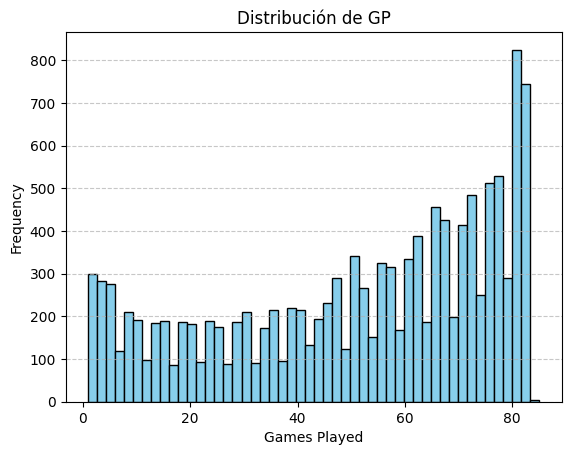

In [12]:
# Distribución partidos jugados

nba_cleanest['gp'].plot.hist(bins=50,edgecolor = 'black', color= 'skyblue')

plt.title('Distribución de GP')
plt.xlabel('Games Played')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha = 0.7)

plt.show

In [13]:
# Estadísticas jugadores que juegan poco

few_matches = nba_cleanest[nba_cleanest['gp'] < 41]

few_matches_clean = few_matches[['gp','draft_round','pts','ast','reb']]

few_matches_clean.describe()

gp          pts          ast          reb
count  4137.000000  4137.000000  4137.000000  4137.000000
mean     19.338893     4.097583     0.948538     2.061591
std      12.111535     3.841375     1.164941     1.721313
min       1.000000     0.000000     0.000000     0.000000
25%       8.000000     1.700000     0.300000     1.000000
50%      19.000000     3.000000     0.600000     1.600000
75%      30.000000     5.100000     1.200000     2.700000
max      40.000000    27.400000    11.100000    16.300000

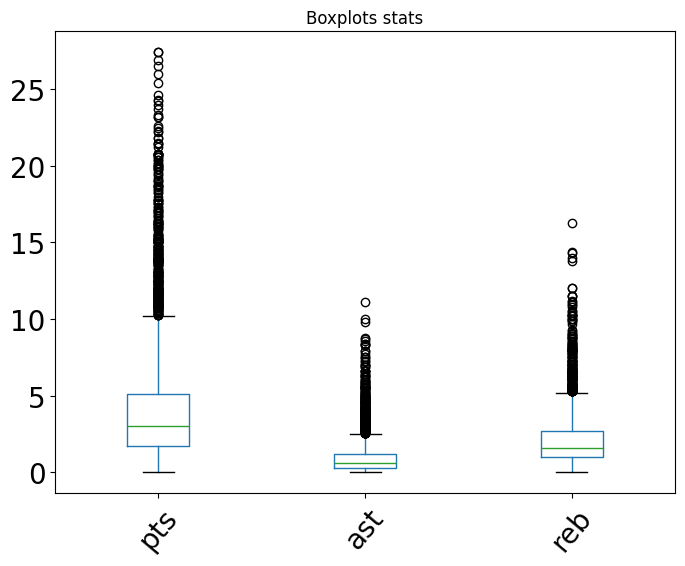

In [14]:
# Grafiquemos este tipo de jugador con Boxplots

boxplot_data = few_matches_clean[['pts','ast','reb']]

plt.figure(figsize=(8, 6))
plt.title('Boxplots stats')
boxplot_data.boxplot(grid=False, rot=50, fontsize=20)
plt.show()

In [15]:
# Outliers de estas distribuciones

few_games_pts = few_matches_clean[few_matches_clean['pts']>10]
few_games_ast = few_matches_clean[few_matches_clean['ast']>2.5]
few_games_reb = few_matches_clean[few_matches_clean['reb']>5]

print(len(few_games_pts['pts']))
print(len(few_games_ast['ast']))
print(len(few_games_reb['reb']))

312
335
231


In [16]:
# Jugadores con más de 41 partidos jugados
condition_1 = nba_cleanest['gp'] > 41

# Jugadores con menos de 41 partidos jugados pero con más de 10 puntos, 2.5 asistencias o 5 rebotes promediados
condition_2 = (nba_cleanest['gp'] <= 41) & ((nba_cleanest['pts'] > 10) | (nba_cleanest['ast'] > 2.5) | (nba_cleanest['reb'] > 5))

# Combinación de ambas
nba_selected_players = nba_cleanest[condition_1 | condition_2]

# Tambien eliminaremos los jugadores que hayan jugado menos del 25% de los partidos (no contamos temporadas de lock-out en los años seleccionados)
nba_selected_players = nba_selected_players[nba_selected_players['gp'] >= 20]

len(nba_selected_players)

9002

In [17]:
len(nba_selected_players)
nba_recent = nba_selected_players[
    (nba_selected_players['season'] == 19) |
    (nba_selected_players['season'] == 20) |
    (nba_selected_players['season'] == 21) |
    (nba_selected_players['season'] == 22) |
    (nba_selected_players['season'] == 23)
]

print(len(nba_recent))

1767


In [18]:
nba_recent.head()

age  player_height  player_weight draft_round draft_number  gp   pts  \
10103  20.0         198.12       90.71840           1            8  43   5.7   
10104  25.0         182.88       88.45044           3           61  64  11.0   
10105  21.0         200.66       86.18248           1           26  48   5.8   
10106  33.0         198.12       88.45044           3           61  75   7.8   
10107  24.0         203.20      102.05820           3           61  51   2.9   

       reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
10103  2.0  2.8        -8.5     0.012     0.080    0.163   0.417    0.195   
10104  2.6  4.8         8.1     0.012     0.078    0.177   0.539    0.243   
10105  2.2  1.1         3.7     0.023     0.130    0.174   0.528    0.107   
10106  2.9  1.4        -1.6     0.014     0.092    0.131   0.543    0.075   
10107  2.3  0.4         2.0     0.035     0.144    0.106   0.480    0.040   

       season  
10103      19  
10104      19  
10105      19  
10106      19  
10107      19

El primer filtro que aplicaremos es entre los jugadores que han jugado menos de la mitad de los partidos de la temporada regular. A partir de ahí, he detectado que seguimos dejando fuera a jugadores con cierto nivel en la liga, y con estadísticas suficientemente importantes como para tenerlos en cuenta y, por último, sí que he decidido dejar fuera a todos aquellos jugadores que, independientemente de sus promedios, no hayan llegado a jugar el 25% de los partidos de la temporada regular, ya que considero que entre estos, la mayoría será información que no nos interesa.

Por otro lado, he considerado acotar el marco temporal en el que se centrará nuestro estudio de 2019 a la actualidad. Después de temporadas de máxima rivalidad entre tan solo dos equipos, la liga se volvió a igualar y muchos más equipos han tenido opciones de llegar a las finales de la NBA o incluso ganar el anillo durante los últimos 5 años. Han existido remontadas increíbles, equipos 'underdog' llegando a las finales y sorpresas mayúsculas, así que considero que es un buen periodo para estudiar y analizar.

Merece la pena mencionar que en todas las temporadas que analizaremos se jugaron los 81 partidos de temporada regular, es decir, en ninguna de ellas hubo un lockout o reducción de los partidos de la temporada como si sucedió al inicio de la primera década de los 2010.

# Exploracion de los datos restantes

<Axes: >

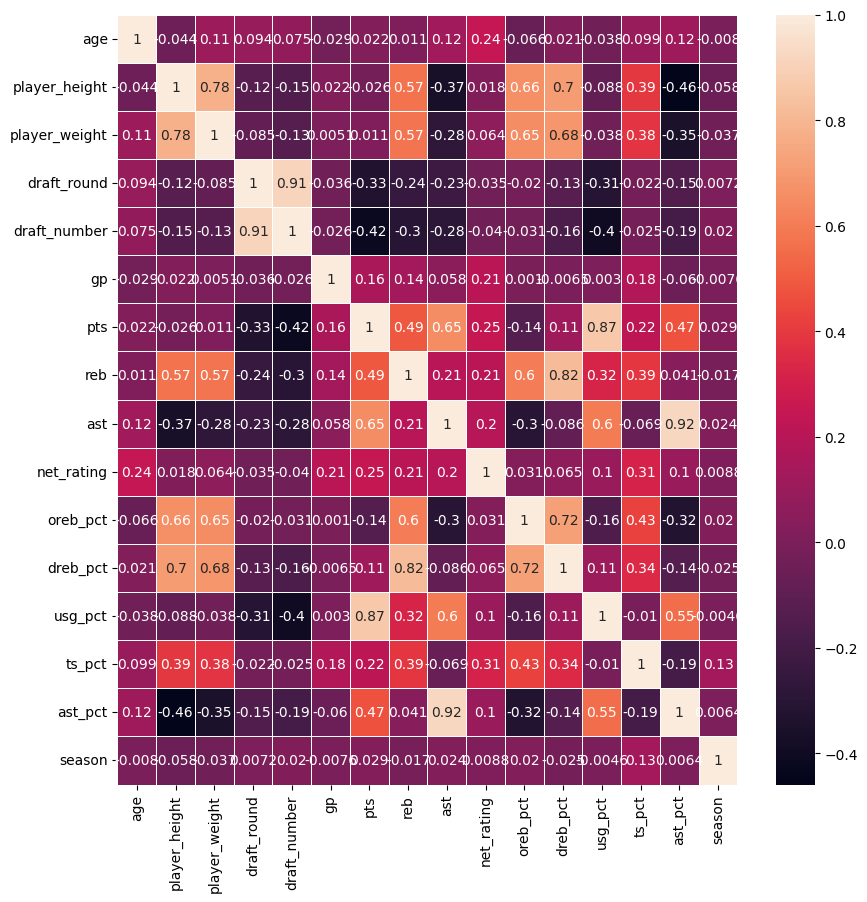

In [19]:
# Graficamos la matriz de correlación de las variables que nos quedamos hasta ahora

plt.figure(figsize=(10, 10))
sns.heatmap(nba_recent.corr(), annot = True, linewidths=0.5)

Con esta información, nos damos cuenta de que hay variables muy correlacionadas que pueden amplificar su información indebidamente y que creo oportuno eliminar antes de seguir con el análisis. El 'thereshold' usado es 0,75 de correlación.

- El peso y la altura, son dos variables que nos aportan prácticamente lo mismo, así que una de las dos debería ser eliminada. Inicialmente, tenía pensado solo eliminar una, pero viendo que ambas variables están altamente relacionadas con diversas más, he decidió eliminar las dos. Para este estudio prefiero céntrame en variables relacionadas con el juego.
- Asistencias y Aspect, también lo están por encima del 75% y, tiene sentido, miden cosas muy similares. En este caso, vamos a eliminar el ast_pct para analizar el valor total de asistencias y no la estadística avanzada. También está más relacionada con peso y altura, así que me parece lo correcto.
- También vemos que los puntos están altamente relacionados con el usg_pct, cosa que tiene sentido debido al tipo de juego, especialmente de los bases de la liga, de los últimos años. Eliminaremos el usg_pct, ya que valoro los puntos como una estadística más importante.
- Otras variables que están relacionadas con los rebotes con los dreb_pct. Aquí sucede lo mismo, valoro quedarme con los rebotes totales, ya que nos dan más información global y eliminaré la variable dreb_pct.
- Draft_round i draft_number también lo están en exceso, así que vamos a eliminar una de las dos, en este caso 'draft_number'. Pero lo haremos más adelante porque nos ayudará en los siguientes pasos.

In [20]:
variables_correlacionadas = nba_recent[['player_weight','player_height','ast_pct','usg_pct','dreb_pct']]
nba_recent = nba_recent.drop(columns = variables_correlacionadas)
nba_recent.head()

age draft_round draft_number  gp   pts  reb  ast  net_rating  \
10103  20.0           1            8  43   5.7  2.0  2.8        -8.5   
10104  25.0           3           61  64  11.0  2.6  4.8         8.1   
10105  21.0           1           26  48   5.8  2.2  1.1         3.7   
10106  33.0           3           61  75   7.8  2.9  1.4        -1.6   
10107  24.0           3           61  51   2.9  2.3  0.4         2.0   

       oreb_pct  ts_pct  season  
10103     0.012   0.417      19  
10104     0.012   0.539      19  
10105     0.023   0.528      19  
10106     0.014   0.543      19  
10107     0.035   0.480      19

<Axes: >

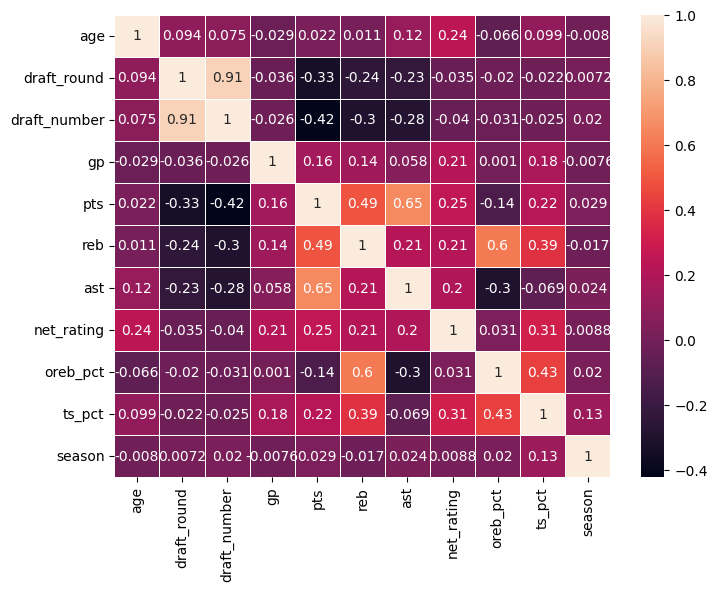

In [21]:
# Graficamos la matriz de correlación de las variables restantes

plt.figure(figsize=(8, 6))
sns.heatmap(nba_recent.corr(), annot = True, linewidths=0.5)

In [22]:
# Repaso concreto de las correalciones con la variable objetivo

correlations = nba_recent.corr()
corr_draftround = correlations['draft_round']
corr_draftround

age             0.093545
draft_round     1.000000
draft_number    0.909612
gp             -0.035855
pts            -0.333372
reb            -0.243717
ast            -0.229263
net_rating     -0.035311
oreb_pct       -0.020483
ts_pct         -0.021802
season          0.007155
Name: draft_round, dtype: float64

<Figure size 2000x1000 with 0 Axes>

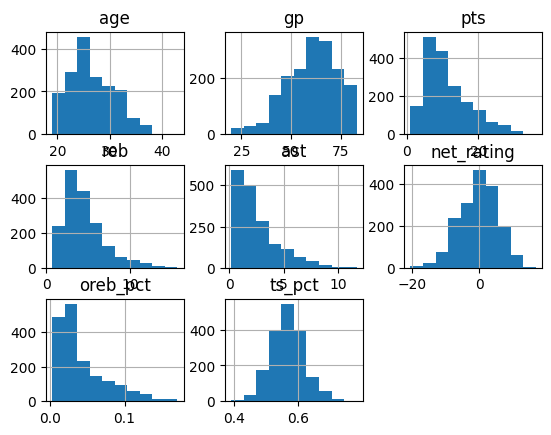

In [23]:
season = ['season']
nba_hist = nba_recent.drop(columns=season)

plt.figure(figsize = (20,10))
nba_hist.hist()
plt.show()

# Clasificación Binaria

Las variables que podríamos usar para la clasificación binaria son varias, pero todas ellas necesitan modificaciones previas, ya que ninguna de las que vienen en el dataset inicialmente se pueden usar sin ellas.

Para nuestro modelo, usaremos la variable 'draft_round', que en caso de que eliminemos a todos los jugadores undrafted (cada vez son menos porque eran la mayoría de los jugadores con muy pocos partidos) podemos tener una variable binaria entre jugadores de primera y segunda ronda.

Veámoslo con este gráfico, por un lado, graficamos los jugadores que usaremos 'Kept_Players' que son los jugadores que han pasado los filtros aplicados anteriormente a nuestro dataset. Por otro, los jugadores que hemos eliminado por falta de partidos jugados.

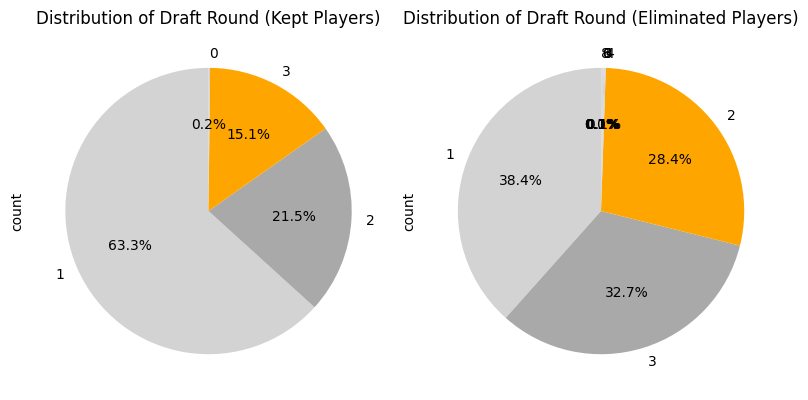

In [24]:
colors = ['lightgray' if round_num != 2 and round_num != 3 else 'darkgray' 
               if round_num == 2 else 'orange' for round_num in range(1, 8)]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Jugadores con los que trabajaremos
nba_recent['draft_round'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[0], 
                                                  colors=colors)

axes[0].set_title('Distribution of Draft Round (Kept Players)')

# Jugadores con pocos partidos 
few_matches_clean['draft_round'].value_counts().plot.pie(autopct='%1.1f%%',startangle=90, ax=axes[1], 
                                                         colors=colors)

axes[1].set_title('Distribution of Draft Round (Eliminated Players)')

plt.tight_layout()
plt.show()


Se ve claramente que los jugadores de la ronda 3, es decir los undrafted, cada vez tienen menos importancia en nuestra distribución, así que los vamos a eliminar.

Por otro lado, también se observa que hay algunos errores en los datos que nos quedan, ya que un porcentaje pequeño de jugadores parece que son de la ronda 0, cosa que no existe y que se debe examinar.

In [25]:
# Comprovamos el error en los datos (tenemos jugadores que han sido elegidos en la ronda 0 del draft)

nba_data_zero = nba_recent[nba_recent['draft_round'] == '0']
nba_data_zero

age draft_round draft_number  gp  pts  reb  ast  net_rating  oreb_pct  \
10966  28.0           0           61  71  6.5  2.7  5.0         1.1     0.028   
11498  29.0           0           61  69  8.6  3.7  6.6         2.5     0.030   
12247  30.0           0           61  27  8.5  3.3  4.9        -5.5     0.029   

       ts_pct  season  
10966   0.540      20  
11498   0.583      21  
12247   0.525      22

Vemos que hay tres observaciones con una ronda del draft igual a cero, la cual cosa no tiene sentido. Parece ser el mismo jugador en distintas temporadas, pero aún así, viendo que su 'draft_number' es de 61, podemos entender que previamente tenía un valor de 'undrafted' en esta variable, la cual cosa nos ayuda, ya que para el estudio que estamos haciendo, hemos eliminado a todos los undrafteds y haremos lo mismo con este.

En el otro gráfico, vemos que sucede lo mismo, pero es menos importante, ya que son datos que ya no usaremos y que solo he añadido a modo de justificar la decisión que estábamos tomando.

In [26]:
# Eliminamos estas tres observaciones
nba_recent = nba_recent[(nba_recent['draft_round'] != '0')]

# Eliminamos los jugadores con 'draft_round' = 3
nba_recent = nba_recent[(nba_recent['draft_round'] != 3)]

In [27]:
# Faltaria eliminar la variable draft_number porque, como hemos visto, nos da demasiada información de draft_round
draft_number = nba_recent[['draft_number']]
nba_recent = nba_recent.drop(columns = draft_number)

In [28]:
nba_recent.head()

age draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct  \
10103  20.0           1  43   5.7  2.0  2.8        -8.5     0.012   0.417   
10105  21.0           1  48   5.8  2.2  1.1         3.7     0.023   0.528   
10108  24.0           1  57  12.9  2.8  2.2         6.2     0.024   0.526   
10111  33.0           1  60   7.6  2.5  2.3         5.6     0.028   0.554   
10113  26.0           2  59   4.0  1.5  0.6        -7.7     0.022   0.613   

       season  
10103      19  
10105      19  
10108      19  
10111      19  
10113      19

In [29]:
print(len(nba_recent))

1498


C:\Users\Marc\AppData\Local\Temp\ipykernel_27488\3926588198.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i], palette='husl')
C:\Users\Marc\AppData\Local\Temp\ipykernel_27488\3926588198.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i], palette='husl')
C:\Users\Marc\AppData\Local\Temp\ipykernel_27488\3926588198.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i],

C:\Users\Marc\AppData\Local\Temp\ipykernel_27488\3926588198.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i], palette='husl')
C:\Users\Marc\AppData\Local\Temp\ipykernel_27488\3926588198.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i], palette='husl')


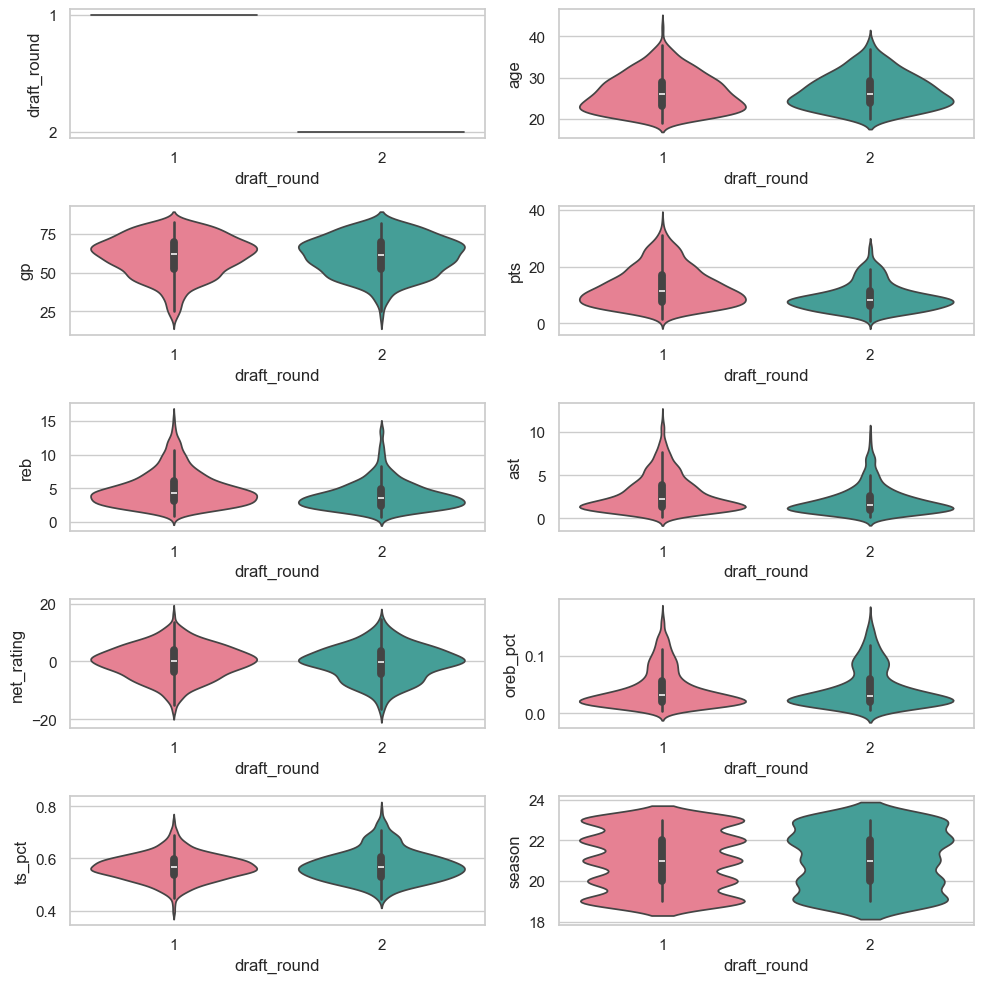

In [30]:
sns.set(style="whitegrid")

selected_features = ['draft_round','age', 'gp', 'pts','reb','ast','net_rating','oreb_pct','ts_pct','season']

fig, axes = plt.subplots(nrows=len(selected_features) // 2, ncols=2, figsize=(10, 2 * (len(selected_features) // 2)))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i], palette='husl')

plt.tight_layout()
plt.show()

<Figure size 1500x1500 with 0 Axes>

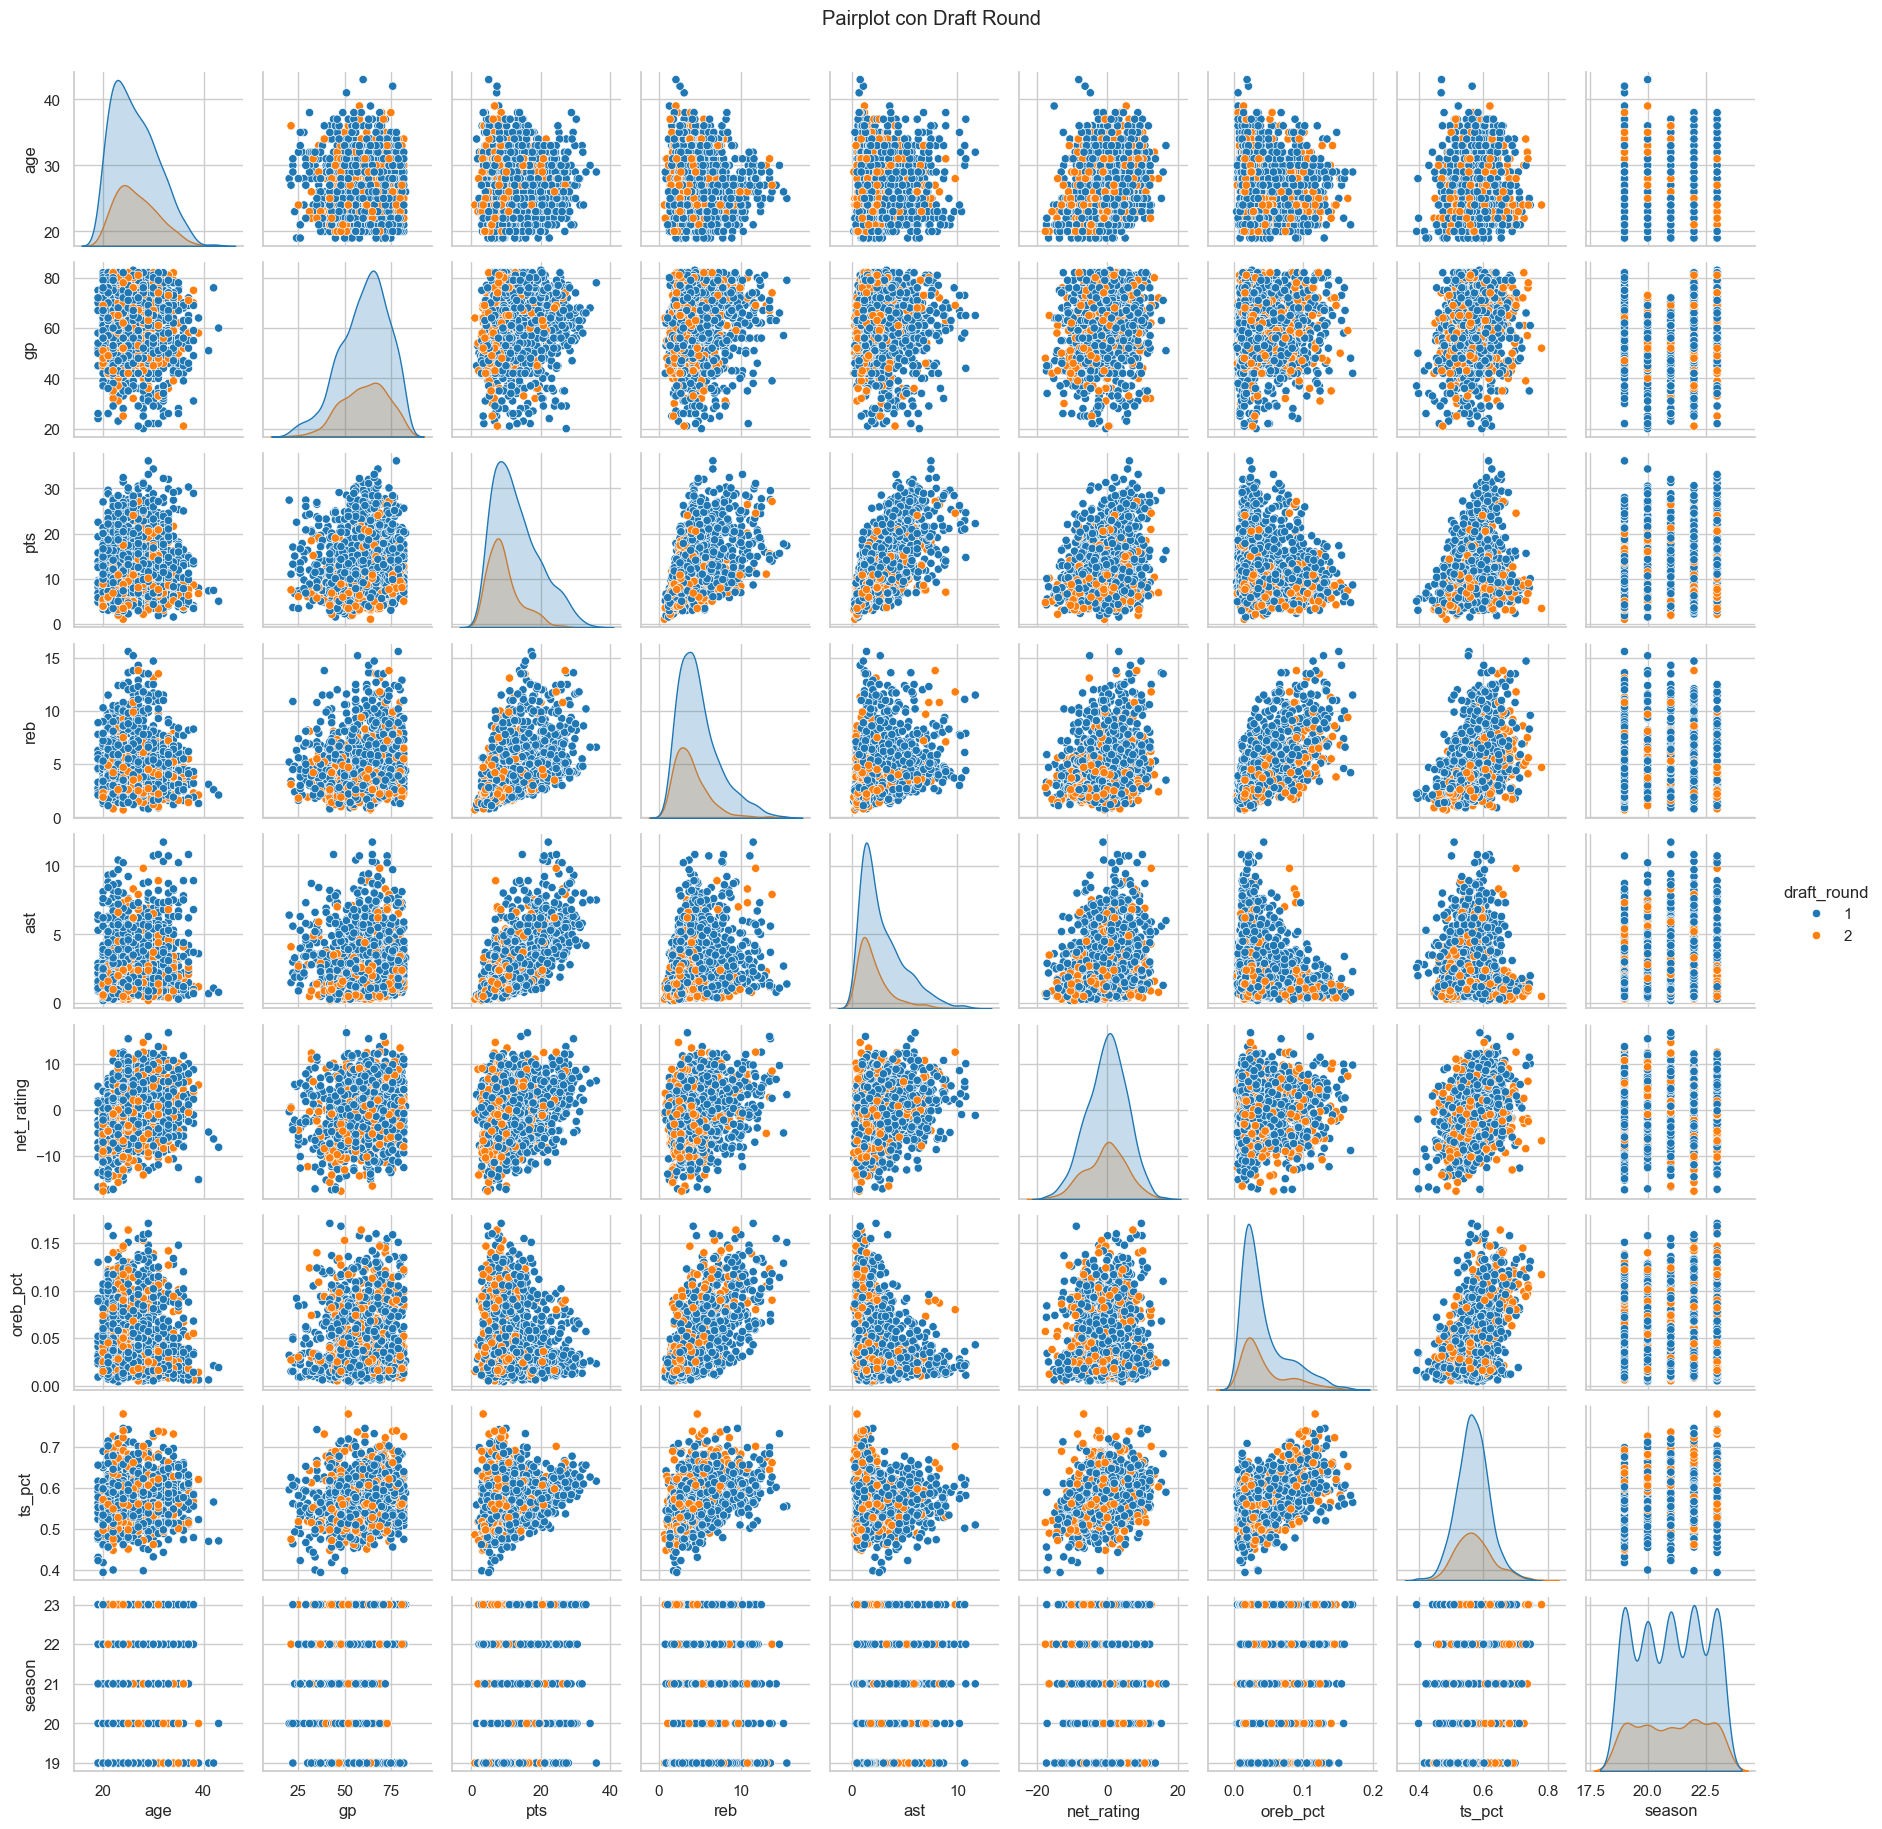

In [31]:
pairplot_data = nba_recent

plt.figure(figsize=(15, 15)) 
sns.pairplot(pairplot_data, height=2, palette='tab10', hue='draft_round')
plt.suptitle('Pairplot con Draft Round', y=1.02) 
plt.show()

Con estos dos últimos gráficos, tenemos una idea un poco más clara de las diferencias (o no) que hay entre los 'grupos' de jugadores de primera y segunda ronda.

Sobre todo el primero gráfico, que normalmente nos ayuda cuando hacemos tests ANOVA, visualiza las distribuciones de cada grupo de forma separada, y sirve para ver si los principales rasgos de la distribución son similares o no entre los grupos. Podemos ver que en pocos grupos hay diferencias remarcables.

En el segundo también intentamos ver la separabilidad de los grupos visualizando los datos en dos dimensiones, observando que, en prácticamente todos los casos, parecen estar bastante mezclados y siguen tendencias difíciles de predecir. También en los gráficos de densidad se ve que la separabilidad entre grupos será complicada.

# Regresión Logística

Hasta aquí hemos hecho las transformaciones necesarias para aplicar la clasificación logística. Necesitábamos una variable binaria, y en el proceso, hemos tenido que organizar nuestro data set y hacer distintas correcciones alrededor de esta para poder obtener un formato de datos que nos permitan aplicar correctamente la Regresión Logística.

Veamos como funciona:

In [32]:
X = nba_recent.drop(columns=['draft_round'])
y = nba_recent['draft_round']

# Normalizamos los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [33]:
# Dividimos el data set entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Modelo de Regresión Logística
model = LogisticRegression(random_state=33)
model.fit(X_train, y_train)

print('Training Data:', len(X_train))
print('Testing Data:', len(y_test))


Training Data: 1198
Testing Data: 300


Accuracy: 0.77

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.95      0.87       236
           2       0.39      0.11      0.17        64

    accuracy                           0.77       300
   macro avg       0.59      0.53      0.52       300
weighted avg       0.71      0.77      0.72       300



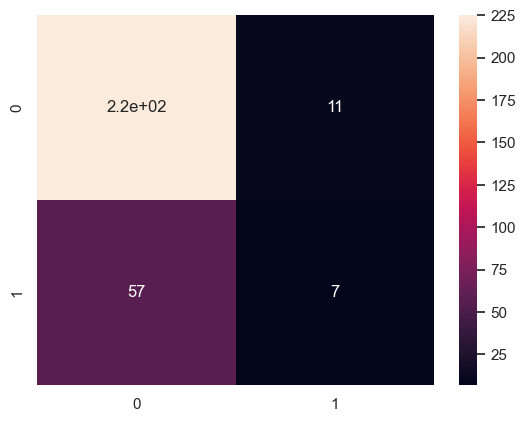

In [34]:
# Hacemos predicciones
y_pred = model.predict(X_test)

# Evaluamos el modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Resultados del modelo
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

El modelo es mejorable. Está acertando en una alta cantidad de los jugadores de primera ronda y fallando en prácticamente todos los jugadores de segunda ronda. Esto debería deberse a que nuestros datos están desbalanceados y la mayoría de ellos son de primera ronda. Vamos a hacer alguna modificación y a intentar mejorarlo:
- Balancearemos los datos, que ahora mismo están demasiado desbalanceados
- Aplicaremos PCA para intentar seleccionar mejor las variables que vayamos a usar

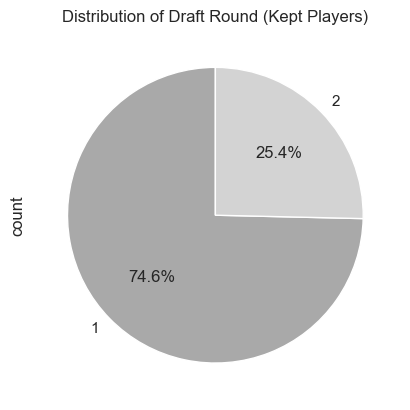

In [35]:
# Ver visualmente datos desbalanceados
colors = ['lightgray' if round_num != 1 else 'darkgray' for round_num in range(1, 8)]

nba_recent['draft_round'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Distribution of Draft Round (Kept Players)')
plt.show()


In [36]:
round1 = nba_recent[nba_recent['draft_round'] == '1']
round2 = nba_recent[nba_recent['draft_round'] == '2']

print(len(round1))
print(len(round2))

1118
380


In [37]:
# Balanceamos los datos
draft_1 = '1'
draft_2 = '2'
reduced_1 = 0.65
reduced_2 = 0.01

indices1 = nba_recent[nba_recent['draft_round'] == draft_1].index
indices2 = nba_recent[nba_recent['draft_round'] == draft_2].index

np.random.seed(33)

reduced1 = np.random.choice(indices1, size=int(len(indices1) * reduced_1), replace=False)
reduced2 = np.random.choice(indices2, size=int(len(indices2) * reduced_2), replace=False)

balanced_nba_recent = nba_recent.drop(set(reduced1).union(set(reduced2)))


In [38]:
balanced_nba_recent.head()

age draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct  \
10108  24.0           1  57  12.9  2.8  2.2         6.2     0.024   0.526   
10113  26.0           2  59   4.0  1.5  0.6        -7.7     0.022   0.613   
10116  25.0           2  47   4.2  1.5  0.4        -0.8     0.026   0.511   
10117  33.0           2  36  13.7  3.1  4.8         1.3     0.019   0.517   
10118  29.0           1  72  11.5  4.5  3.4         5.1     0.026   0.575   

       season  
10108      19  
10113      19  
10116      19  
10117      19  
10118      19

In [39]:
len(balanced_nba_recent['draft_round'])

769

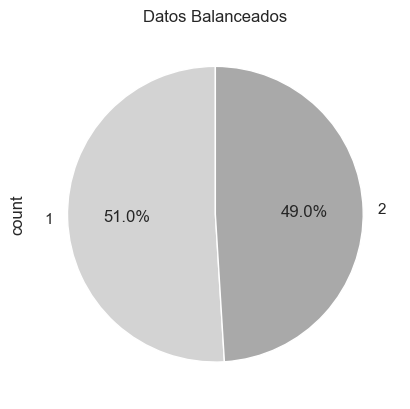

In [40]:
# Datos balanceados
colors = ['lightgray', 'darkgray']
balanced_nba_recent['draft_round'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Datos Balanceados')
plt.show()


In [41]:
# Probamos de hacer el modelo otra vez, para ver si los resultados mejoran
X_2 = balanced_nba_recent.drop(columns=['draft_round'])
y_2 = balanced_nba_recent['draft_round']

scaler = StandardScaler()
X_2 = scaler.fit_transform(X_2)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=33)

model = LogisticRegression(random_state=33)
model.fit(X_train_2, y_train_2)

print('Training Data:', len(X_train_2))
print('Testing Data:', len(y_test_2))

Training Data: 615
Testing Data: 154


Accuracy: 0.64

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.60      0.61        72
           2       0.66      0.68      0.67        82

    accuracy                           0.64       154
   macro avg       0.64      0.64      0.64       154
weighted avg       0.64      0.64      0.64       154



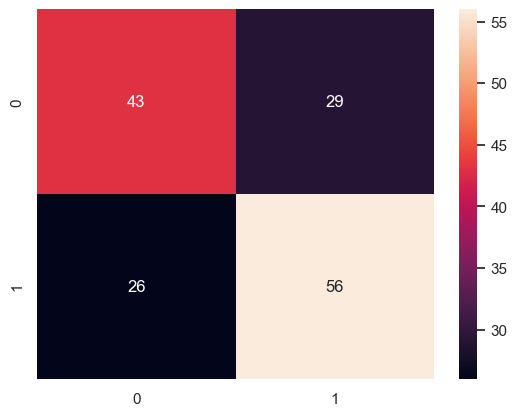

In [42]:
y_pred_2= model.predict(X_test_2)

accuracy = accuracy_score(y_test_2, y_pred_2)
conf_matrix = confusion_matrix(y_test_2, y_pred_2)
classification_rep = classification_report(y_test_2, y_pred_2)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

No es el caso, como observamos en los resultados, la precisión del modelo disminuye en 0,15 puntos y las predicciones son peores. Dicho esto, mejoramos bastante en las predicciones de los jugadores que saldrán en segunda ronda, acertando en un porcentaje más alto de estos. Merece la pena seguir probando métodos, para ver si podemos mejorar estos resultados.

In [43]:
# PCA
from sklearn.decomposition import PCA

pca = PCA()

x_new = pca.fit_transform(X_2)

In [44]:
pca.explained_variance_ratio_

array([0.26744232, 0.20627993, 0.12784177, 0.11114281, 0.10984188,
       0.07212141, 0.0585761 , 0.03300326, 0.01375052])

Los resultados nos dan una varianza explicada dividida entre demasiados componentes y creo que, con el conocimiento del dominio que tenemos, podemos eliminar alguna variable más y volver a aplicar el modelo para obtener resultados algo más claros.

Creo que las variables edad y temporadas son muy poco importantes de cara al análisis que estamos haciendo, así que las vamos a eliminar.

In [45]:
edad_temporada = ['season','age']
balanced_nba_recent = balanced_nba_recent.drop(columns=edad_temporada)
balanced_nba_recent.head()

draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct
10108           1  57  12.9  2.8  2.2         6.2     0.024   0.526
10113           2  59   4.0  1.5  0.6        -7.7     0.022   0.613
10116           2  47   4.2  1.5  0.4        -0.8     0.026   0.511
10117           2  36  13.7  3.1  4.8         1.3     0.019   0.517
10118           1  72  11.5  4.5  3.4         5.1     0.026   0.575

In [46]:
X_pca = balanced_nba_recent.drop(columns=['draft_round'])
y_pca = balanced_nba_recent['draft_round']

scaler = StandardScaler()
X_pca = scaler.fit_transform(X_pca)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=33)

model = LogisticRegression(random_state=33)
model.fit(X_train_2, y_train_2)

print('Training Data:', len(X_train_2))
print('Testing Data:', len(y_test_2))

Training Data: 615
Testing Data: 154


In [47]:
pca = PCA()

x_new = pca.fit_transform(X_pca)

In [48]:
pca.explained_variance_ratio_

array([0.33925878, 0.26337357, 0.14537445, 0.11037434, 0.07921717,
       0.04410408, 0.01829761])

In [49]:
# Analizamos los cuatro primeros componenetes que nos dan información sobre el 86% de la varianza de la variable objetivo

abs( pca.components_ )


array([[0.23998336, 0.45931043, 0.53173988, 0.29410208, 0.35012857,
        0.27200645, 0.40696568],
       [0.13132332, 0.39475027, 0.19616192, 0.54450577, 0.09949553,
        0.60432138, 0.34184307],
       [0.72133596, 0.21425879, 0.32565988, 0.28151958, 0.41815922,
        0.17808044, 0.20467093],
       [0.59937763, 0.0886458 , 0.15277538, 0.03695496, 0.77147566,
        0.08673607, 0.07405782],
       [0.20697691, 0.27052653, 0.34833368, 0.05251314, 0.3066879 ,
        0.28541951, 0.76443457],
       [0.03848303, 0.54418866, 0.22959169, 0.73049565, 0.03673837,
        0.25087344, 0.22749577],
       [0.03553414, 0.45838341, 0.61264168, 0.00411936, 0.04551514,
        0.61414215, 0.18448026]])

In [50]:
balanced_nba_recent.head()

draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct
10108           1  57  12.9  2.8  2.2         6.2     0.024   0.526
10113           2  59   4.0  1.5  0.6        -7.7     0.022   0.613
10116           2  47   4.2  1.5  0.4        -0.8     0.026   0.511
10117           2  36  13.7  3.1  4.8         1.3     0.019   0.517
10118           1  72  11.5  4.5  3.4         5.1     0.026   0.575

Del componente 1 vemos que las variables con más impacto son la variable 2, la variable 3.

En el componente 2 vemos las variables 4 y 6 son muy importantes

Para el componente 3, seleccionaremos las variables 1 y 6.

Y por último, en el componente 4 las variables más importantes vuelven a ser la primera y la sexta.

Vistos estos resultados, la realidad es que este método nos ayudará a reducir algunas variables, pero seguimos teniendo una cantidad importante. Podemos concluir que las variables que más relacionadas están con los componentes que más información nos dan sobre el modelo son las variables 1, 2, 3, 4 y 6:
- GP (partidos jugados)
- PTS (puntos)
- REB (rebotes)
- AST (asistencias)
- OREB_PCT (porcentaje de rebotes ofensivos)

Una vez tenemos el data set balanceado y las cinco variables más importantes seleccionadas, vamos a intentar rehacer el modelo con estos datos.

In [51]:
nba_balanced_pca = balanced_nba_recent[['draft_round','gp','pts','reb','ast','oreb_pct']]

In [52]:
nba_balanced_pca.head()

draft_round  gp   pts  reb  ast  oreb_pct
10108           1  57  12.9  2.8  2.2     0.024
10113           2  59   4.0  1.5  0.6     0.022
10116           2  47   4.2  1.5  0.4     0.026
10117           2  36  13.7  3.1  4.8     0.019
10118           1  72  11.5  4.5  3.4     0.026

In [53]:
X_3 = nba_balanced_pca.drop(columns=['draft_round'])
y_3 = nba_balanced_pca['draft_round']

# Scaler to avoid the error
scaler = StandardScaler()
X_3 = scaler.fit_transform(X_3)


# Split the dataset into training and testing sets
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=33)

# Initialize and train the logistic regression model
model = LogisticRegression(random_state=33)
model.fit(X_train_3, y_train_3)

print('Training Data:', len(X_train_3))
print('Testing Data:', len(y_test_3))


Training Data: 615
Testing Data: 154


Accuracy: 0.59

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.56      0.56        72
           2       0.61      0.62      0.62        82

    accuracy                           0.59       154
   macro avg       0.59      0.59      0.59       154
weighted avg       0.59      0.59      0.59       154



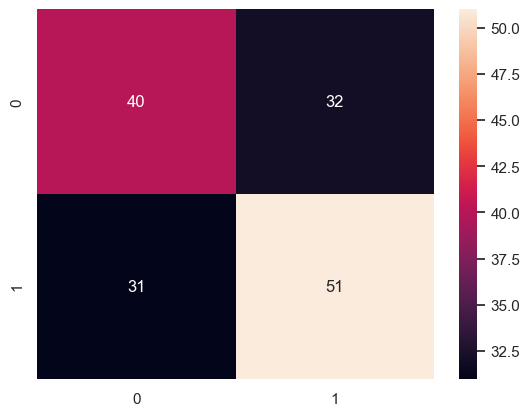

In [54]:
# Make predictions on the test set
y_pred_3 = model.predict(X_test_3)

# Evaluate the model
accuracy = accuracy_score(y_test_3, y_pred_3)
conf_matrix = confusion_matrix(y_test_3, y_pred_3)
classification_rep = classification_report(y_test_3, y_pred_3)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

La realidad es que hemos vuelto a empeorar el modelo. Como se observa en la matriz de correlación y los resultados, la precisión de estos ha vuelto a bajar con la eliminación de variables y hay más balanceo entre la calidad de las predicciones de cada grupo, los resultados nos dicen que con los intentos de corrección hemos reducido la precisión general del modelo creado.

# Árbol de Decisión - Clasificación Binaria

Para el Árbol de decisión vamos a usar la misma variable creada anteriormente. La diferencia es que, en este caso, no tendríamos por qué eliminar a los jugadores 'undrafted', ya que este algoritmo sí está pensado para la clasificación multiclase. Dicho esto, creo que es una buena idea hacer los dos modelos:
- Uno con la variable binaria (primera o segunda ronda)
- Otro con una variable multicalse (primera o segunda ronda y jugadores no drafteados)

In [55]:
nba_decisiontree = nba_recent
nba_decisiontree.head()

age draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct  \
10103  20.0           1  43   5.7  2.0  2.8        -8.5     0.012   0.417   
10105  21.0           1  48   5.8  2.2  1.1         3.7     0.023   0.528   
10108  24.0           1  57  12.9  2.8  2.2         6.2     0.024   0.526   
10111  33.0           1  60   7.6  2.5  2.3         5.6     0.028   0.554   
10113  26.0           2  59   4.0  1.5  0.6        -7.7     0.022   0.613   

       season  
10103      19  
10105      19  
10108      19  
10111      19  
10113      19

In [56]:
X_4 = nba_decisiontree.drop(columns=['draft_round'])
y_4 = nba_decisiontree['draft_round']

# Scaler to avoid the error
scaler = StandardScaler()
X_4 = scaler.fit_transform(X_4)


# Split the dataset into training and testing sets
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=33)

# Initialize and train the logistic regression model

print('Training Data:', len(X_train_4))
print('Testing Data:', len(y_test_4))


Training Data: 1198
Testing Data: 300


In [57]:
model_params={
    'max_leaf_nodes':[50,100,500],
    'min_samples_split':[2,4,6,8]
}

In [58]:
model = DecisionTreeClassifier(random_state=33)
gscv = GridSearchCV(model, model_params, cv =8)
model_gs = gscv.fit(X_train_4, y_train_4)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))

Best: 0.707880 using {'max_leaf_nodes': 50, 'min_samples_split': 4}


Accuracy: 0.67

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.75      0.78       236
           2       0.30      0.39      0.34        64

    accuracy                           0.67       300
   macro avg       0.56      0.57      0.56       300
weighted avg       0.71      0.67      0.69       300



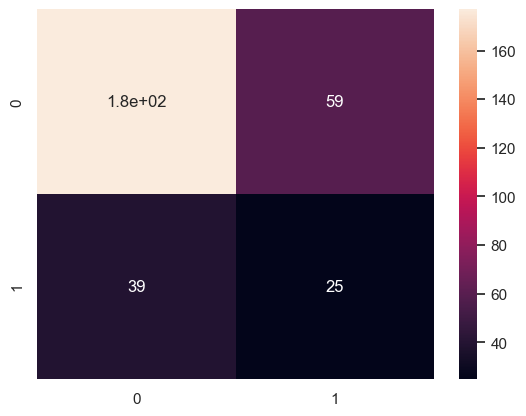

In [59]:
model = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=8, criterion='entropy')
model.fit(X_train_4,y_train_4)
prediction = model.predict(X_test_4)

# Evaluate the model
conf_matrix = confusion_matrix(y_test_4, prediction)
classification_rep = classification_report(y_test_4, prediction)
accuracy = accuracy_score(y_test_4, prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

Para empezar, hemos creado un primero modelo con todas las variables que hemos seleccionado inicialmente para el modelo de regresión. Los resultados no son especialmente buenos, ya que vemos que tiene una precisión de 0,67 y nos sucede algo parecido al primer modelo que hemos creado con la Regresión Logística, acertamos mucho más en la primera variable porque es donde tenemos la mayoría de los datos. Vamos a volver a hacer el proceso de balanceo y selección de variables para intentar mejorar el modelo. 

Relacionado con la selección, el primer paso que haremos es volver a eliminar las dos variables, age y season, que antes hemos considerado que no aportaban lo suficiente al modelo como para mantenerlas dentro.

In [60]:
round1 = nba_decisiontree[nba_decisiontree['draft_round'] == '1']
round2 = nba_decisiontree[nba_decisiontree['draft_round'] == '2']

print(len(round1))
print(len(round2))

1118
380


In [61]:
draft_1 = '1'
draft_2 = '2'
reduced_1 = 0.65
reduced_2 = 0.01

indices1 = nba_decisiontree[nba_decisiontree['draft_round'] == draft_1].index
indices2 = nba_decisiontree[nba_decisiontree['draft_round'] == draft_2].index

np.random.seed(33)

reduced1 = np.random.choice(indices1, size=int(len(indices1) * reduced_1), replace=False)
reduced2 = np.random.choice(indices2, size=int(len(indices2) * reduced_2), replace=False)

balanced_nba_tree = nba_decisiontree.drop(set(reduced1).union(set(reduced2)))


In [62]:
balanced_nba_tree.head()

age draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct  \
10108  24.0           1  57  12.9  2.8  2.2         6.2     0.024   0.526   
10113  26.0           2  59   4.0  1.5  0.6        -7.7     0.022   0.613   
10116  25.0           2  47   4.2  1.5  0.4        -0.8     0.026   0.511   
10117  33.0           2  36  13.7  3.1  4.8         1.3     0.019   0.517   
10118  29.0           1  72  11.5  4.5  3.4         5.1     0.026   0.575   

       season  
10108      19  
10113      19  
10116      19  
10117      19  
10118      19

In [63]:
balanced_nba_tree = balanced_nba_tree.drop(columns=['age','season'])
balanced_nba_tree.head()

draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct
10108           1  57  12.9  2.8  2.2         6.2     0.024   0.526
10113           2  59   4.0  1.5  0.6        -7.7     0.022   0.613
10116           2  47   4.2  1.5  0.4        -0.8     0.026   0.511
10117           2  36  13.7  3.1  4.8         1.3     0.019   0.517
10118           1  72  11.5  4.5  3.4         5.1     0.026   0.575

In [64]:
X_5 = balanced_nba_tree.drop(columns=['draft_round'])
y_5 = balanced_nba_tree['draft_round']

# Scaler to avoid the error
scaler = StandardScaler()
X_5 = scaler.fit_transform(X_5)


# Split the dataset into training and testing sets
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_5))
print('Testing Data:', len(y_test_5))


Training Data: 615
Testing Data: 154


In [65]:
model_2 = DecisionTreeClassifier(random_state=33)
gscv = GridSearchCV(model_2, model_params, cv =8)
model_gs = gscv.fit(X_train_5, y_train_5)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))

Best: 0.591763 using {'max_leaf_nodes': 100, 'min_samples_split': 8}


Accuracy: 0.58

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.40      0.47        72
           2       0.58      0.73      0.65        82

    accuracy                           0.58       154
   macro avg       0.58      0.57      0.56       154
weighted avg       0.58      0.58      0.57       154



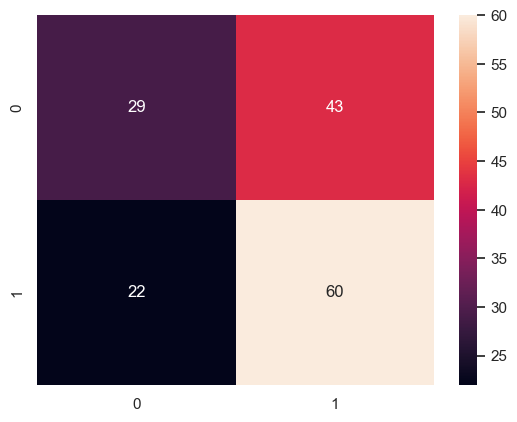

In [66]:
model_2 = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=8, criterion='entropy')
model_2.fit(X_train_5,y_train_5)
prediction = model_2.predict(X_test_5)

# Evaluate the model
accuracy = accuracy_score(y_test_5, prediction)
conf_matrix = confusion_matrix(y_test_5, prediction)
classification_rep = classification_report(y_test_5, prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

Como ha sucedido en el caso anterior, nuestro modelo pierde calidad cuando reducimos el número de variables y cuando balanceamos los datos, así que por lo que parece con los resultados, no deberíamos hacerlo y deberíamos mantener los datos como los teníamos inicialmente. En este caso, estamos mejorando otra vez la predicción de los jugadores de segunda ronda pero estamos perdiendo muchísima calidad en las predicciones de los jugadores de primera ronda.

# Árboles de Decisión - Clasificación Multiclase

Teniendo en cuenta que es el algoritmo base para la clasificación multiclase, tiene sentido que intentemos usarlo para ello. La variable seleccionada como variable objetivo nos sirve también para ello, ya que en este caso, vamos a proceder igual, pero intentando buscar una clasificación también entre los jugadores 'undrafted', que en nuestro dataset, son los jugadores de 'draft_round' = 3.

In [67]:
nba_cleanest

age  player_height  player_weight draft_round draft_number  gp   pts  \
0      22.0         193.04      94.800728           2           42  64   3.9   
1      28.0         190.50      86.182480           2           34   4   3.8   
2      26.0         203.20     103.418976           1           12  41   8.3   
3      30.0         203.20     102.058200           1            7  64  10.2   
4      23.0         213.36     119.748288           1           22  52   2.8   
...     ...            ...            ...         ...          ...  ..   ...   
12839  29.0         213.36     127.005760           1            3  66  33.1   
12840  20.0         213.36      86.182480           3           61  19   2.4   
12841  25.0         205.74     102.511792           1           19  71  13.1   
12842  24.0         208.28     113.398000           2           58  52   3.4   
12843  33.0         205.74     102.965384           3           61  57   6.4   

        reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0       1.5  2.4         0.3     0.042     0.071    0.169   0.487    0.248   
1       1.3  0.3         8.9     0.030     0.111    0.174   0.497    0.043   
2       6.4  1.9        -8.2     0.106     0.185    0.175   0.512    0.125   
3       2.8  1.7        -2.7     0.027     0.111    0.206   0.527    0.125   
4       1.7  0.3       -14.1     0.102     0.169    0.195   0.500    0.064   
...     ...  ...         ...       ...       ...      ...     ...      ...   
12839  10.2  4.2         8.8     0.057     0.243    0.370   0.655    0.233   
12840   0.9  0.6       -16.1     0.012     0.065    0.102   0.411    0.066   
12841   6.5  1.2        -0.2     0.035     0.180    0.168   0.593    0.052   
12842   4.7  0.5        -6.7     0.117     0.175    0.074   0.780    0.044   
12843   3.6  0.9        -8.2     0.087     0.164    0.169   0.650    0.094   

       season  
0          97  
1          97  
2          97  
3          97  
4          97  
...       ...  
12839      23  
12840      23  
12841      23  
12842      23  
12843      23  

[12844 rows x 16 columns]

In [68]:
# Reutilizamos el data set nba_cleanest y lo limpiamos

# Eliminamos jugadores con poco peso en la liga
condition_1 = nba_cleanest['gp'] > 41
condition_2 = (nba_cleanest['gp'] <= 41) & ((nba_cleanest['pts'] > 10) | (nba_cleanest['ast'] > 2.5) | (nba_cleanest['reb'] > 5))

nba_selected_players_multiclase = nba_cleanest[condition_1 | condition_2]
nba_selected_players_multiclase = nba_selected_players[nba_selected_players['gp'] >= 20]

len(nba_selected_players_multiclase)

9002

In [69]:
# Seleccionamos datos de los últimos años
nba_multiclase = nba_selected_players_multiclase[
    (nba_selected_players_multiclase['season'] == 19) |
    (nba_selected_players_multiclase['season'] == 20) |
    (nba_selected_players_multiclase['season'] == 21) |
    (nba_selected_players_multiclase['season'] == 22) |
    (nba_selected_players_multiclase['season'] == 23)
]

len(nba_multiclase)

1767

In [70]:
# Eliminamos variables innecesarias
nba_multiclase = nba_multiclase.drop(columns = ['age','player_height','player_weight','draft_number','dreb_pct','usg_pct','ast_pct','season'])

nba_multiclase

draft_round  gp   pts   reb  ast  net_rating  oreb_pct  ts_pct
10103           1  43   5.7   2.0  2.8        -8.5     0.012   0.417
10104           3  64  11.0   2.6  4.8         8.1     0.012   0.539
10105           1  48   5.8   2.2  1.1         3.7     0.023   0.528
10106           3  75   7.8   2.9  1.4        -1.6     0.014   0.543
10107           3  51   2.9   2.3  0.4         2.0     0.035   0.480
...           ...  ..   ...   ...  ...         ...       ...     ...
12837           3  46   6.9   2.8  3.3         2.5     0.012   0.616
12839           1  66  33.1  10.2  4.2         8.8     0.057   0.655
12841           1  71  13.1   6.5  1.2        -0.2     0.035   0.593
12842           2  52   3.4   4.7  0.5        -6.7     0.117   0.780
12843           3  57   6.4   3.6  0.9        -8.2     0.087   0.650

[1767 rows x 8 columns]

In [71]:
# Recordamos que teníamos tres observaciones que pertenecían a un mismo jugador 'undrafted', hace falta arreglarlo
nba_multiclase.loc[nba_multiclase['draft_round'] == '0', 'draft_round'] = '3'
nba_multiclase['draft_round'] = nba_multiclase['draft_round'].astype(int)


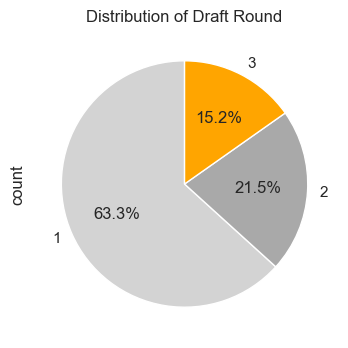

In [72]:
colors = ['lightgray' if round_num != 2 and round_num != 3 else 'darkgray' 
               if round_num == 2 else 'orange' for round_num in range(1, 8)]

plt.figure(figsize=(8, 4))
nba_multiclase['draft_round'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Distribution of Draft Round')
plt.show()



In [73]:
X_6 = nba_multiclase.drop(columns=['draft_round'])
y_6 = nba_multiclase['draft_round']

# Scaler to avoid the error
scaler = StandardScaler()
X_6 = scaler.fit_transform(X_6)


# Split the dataset into training and testing sets
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_6, y_6, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_6))
print('Testing Data:', len(y_test_6))

Training Data: 1413
Testing Data: 354


In [74]:
model_params={
    'max_leaf_nodes':[50,100,500,1000],
    'min_samples_split':[2,4,6,8,10,12]
}

In [75]:
model_3 = DecisionTreeClassifier(random_state=33)
gscv = GridSearchCV(model_3, model_params, cv =8)
model_gs = gscv.fit(X_train_6, y_train_6)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))

Best: 0.590287 using {'max_leaf_nodes': 50, 'min_samples_split': 6}


Accuracy: 0.60

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.87      0.75       228
           2       0.34      0.15      0.21        72
           3       0.23      0.09      0.13        54

    accuracy                           0.60       354
   macro avg       0.41      0.37      0.36       354
weighted avg       0.53      0.60      0.55       354



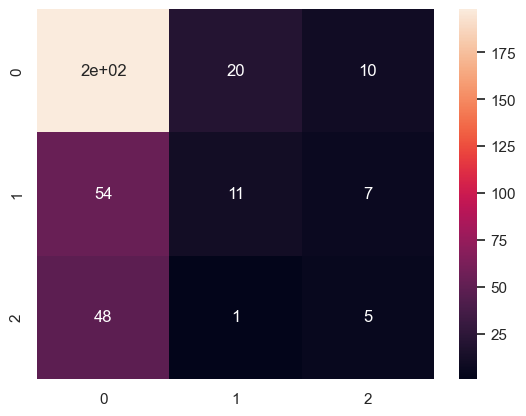

In [76]:
model_3 = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=6, criterion='entropy')
model_3.fit(X_train_6,y_train_6)
prediction = model_3.predict(X_test_6)

# Evaluate the model
accuracy = accuracy_score(y_test_6, prediction)
conf_matrix = confusion_matrix(y_test_6, prediction)
classification_rep = classification_report(y_test_6, prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

El modelo vuelve a tener el mismo problema que en los anteriores casos, empezamos probando con los datos desbalanceados, en este caso en exceso, y esto genera la falsa sensación de que el modelo no es del todo malo, pero sobre todo esto viene dado porque predice que prácticamente todos los jugadores son de primera ronda y acierta en muchos porque la mayoría de nuestros datos provienen de jugadores de primera ronda.

In [77]:
round1 = nba_multiclase[nba_multiclase['draft_round'] == 1]
round2 = nba_multiclase[nba_multiclase['draft_round'] == 2]
round3 = nba_multiclase[nba_multiclase['draft_round'] == 3]

print(len(round1))
print(len(round2))
print(len(round3))

1118
380
269


In [78]:
draft_1 = 1
draft_2 = 2
draft_3 = 3
reduced_1 = 0.75
reduced_2 = 0.25
reduced_3 = 0.01

indices1 = nba_multiclase[nba_multiclase['draft_round'] == draft_1].index
indices2 = nba_multiclase[nba_multiclase['draft_round'] == draft_2].index
indices3 = nba_multiclase[nba_multiclase['draft_round'] == draft_3].index

np.random.seed(33)

reduced1 = np.random.choice(indices1, size=int(len(indices1) * reduced_1), replace=False)
reduced2 = np.random.choice(indices2, size=int(len(indices2) * reduced_2), replace=False)
reduced3 = np.random.choice(indices3, size=int(len(indices3) * reduced_3), replace=False)


balanced_nba_multiclase = nba_multiclase.drop(set(reduced1).union(set(reduced2)).union(set(reduced3)))

In [79]:
round1 = balanced_nba_multiclase[balanced_nba_multiclase['draft_round'] == 1]
round2 = balanced_nba_multiclase[balanced_nba_multiclase['draft_round'] == 2]
round3 = balanced_nba_multiclase[balanced_nba_multiclase['draft_round'] == 3]

print(len(round1))
print(len(round2))
print(len(round3))

280
285
267


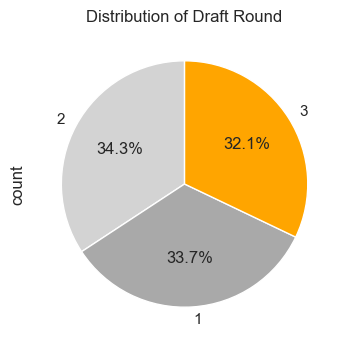

In [80]:
colors = ['lightgray' if round_num != 2 and round_num != 3 else 'darkgray' 
               if round_num == 2 else 'orange' for round_num in range(1, 8)]

plt.figure(figsize=(8, 4))
balanced_nba_multiclase['draft_round'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Distribution of Draft Round')
plt.show()

In [81]:
X_7 = balanced_nba_multiclase.drop(columns=['draft_round'])
y_7 = balanced_nba_multiclase['draft_round']

# Scaler to avoid the error
scaler = StandardScaler()
X_7 = scaler.fit_transform(X_7)


# Split the dataset into training and testing sets
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_7, y_7, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_7))
print('Testing Data:', len(y_test_7))

Training Data: 665
Testing Data: 167


In [82]:
model_params={
    'max_leaf_nodes':[50,100,500],
    'min_samples_split':[2,4,6,8,10]
}



In [83]:
model_4 = DecisionTreeClassifier(random_state=33)
gscv = GridSearchCV(model_4, model_params, cv =6)
model_gs = gscv.fit(X_train_7, y_train_7)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))

Best: 0.452553 using {'max_leaf_nodes': 50, 'min_samples_split': 6}


Accuracy: 0.40

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.39      0.41        57
           2       0.43      0.25      0.31        65
           3       0.36      0.64      0.46        45

    accuracy                           0.40       167
   macro avg       0.41      0.43      0.40       167
weighted avg       0.42      0.40      0.39       167



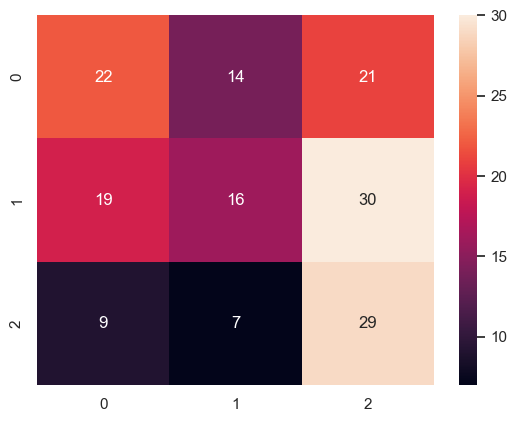

In [84]:
model_4 = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=6, criterion='entropy')
model_4.fit(X_train_7,y_train_7)
prediction = model_4.predict(X_test_7)

# Evaluate the model
accuracy = accuracy_score(y_test_7, prediction)
conf_matrix = confusion_matrix(y_test_7, prediction)
classification_rep = classification_report(y_test_7, prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

Como en los casos anteriores, nuestros resultados empeoran mucho cuando intentamos tratar los datos. Probablemente, esto se debe a que eliminamos la 'artificialidad' que nos daba el hecho de crear un modelo que nos predijera sobre todo jugadores de primera ronda, equivocándose en lo demás pero acertando en un porcentaje alto de esos primeros jugadores.

La teoría dice que el modelo debería mejorar y sobre todo que siempre hay que tener los datos balanceados, pero en este caso, parece que no nos está funcionando.

# KNN - Clasificación Multiclase

Ahora que tenemos esta variable como una variable categórica de 3 clases, merece la pena probar el tercer algoritmo que hemos visto en clase, que es teóricamente el que más costes computacionales tiene y, sobre todo, el que peor reacciona al ruido o variables sobrantes.

Teniendo en cuenta las dos características que acabamos de mencionar, creo que, en este caso, merece la pena hacer una selección de variables, más profunda aún, a la hecha anteriormente.

Para ello, seleccionaremos directamente el dataset balanced_nba_multiclase donde algunas de las variables con menos importancia ya están eliminadas y tenemos los datos seleccionados y además usaremos la función GridSearch para buscar la mejor K.

In [85]:
X_8 = balanced_nba_multiclase.drop(columns=['draft_round'])
y_8 = balanced_nba_multiclase['draft_round']

# Scaler to avoid the error
scaler = StandardScaler()
X_8 = scaler.fit_transform(X_8)


# Split the dataset into training and testing sets
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(X_8, y_8, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_8))
print('Testing Data:', len(y_test_8))

Training Data: 665
Testing Data: 167


In [86]:
inicio = time.time()
np.random.seed(1633)
knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [87]:
param_grid = {"n_neighbors": [2, 3, 5, 7, 9, 11]}

knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")
knn_grid.fit(X_train_8, y_train_8)

print("Mejores parámetros:", knn_grid.best_params_)

Mejores parámetros: {'n_neighbors': 3}


Tiempo de procesado: 0.45701122283935547 seg
Accuracy: 0.4731
Precision: 0.4750
Recall: 0.4731

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.39      0.41        57
           2       0.43      0.25      0.31        65
           3       0.36      0.64      0.46        45

    accuracy                           0.40       167
   macro avg       0.41      0.43      0.40       167
weighted avg       0.42      0.40      0.39       167



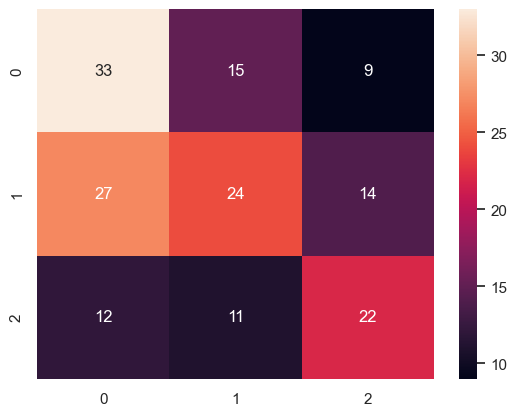

In [88]:
best_knn_model = knn_grid.best_estimator_

y_pred_knn = best_knn_model.predict(X_test_8)

final = time.time()
tiempo = final - inicio
print(f'Tiempo de procesado: {tiempo} seg')

accuracy = accuracy_score(y_test_8, y_pred_knn)
precision = precision_score(y_test_8, y_pred_knn, average="weighted")
recall = recall_score(y_test_8, y_pred_knn, average="weighted")
conf_matrix = confusion_matrix(y_test_8, y_pred_knn)
classification_rep = classification_report(y_test_7, prediction)


print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)


Los resultados del modelo KNN son realmente bajos, ya que pese a tener los datos balanceados, limpios y haber seleccionado la mejor K, el modelo solo predice correctamente el 47% de las observaciones. Se debe observar que en este caso no pasa como en los anteriores, al no haber desbalanceo, la primera ronda no está sobre poblada y no hay un nivel de acierto sobredimensionado.

Aunque es un modelo que tiende a tener problemas de cómputo, con la cantidad de datos que estamos usando no ha dado ningún tipo de problema y el tiempo de procesado es corto, de tan solo 0,59 segundos.

# Conclusiones

A lo largo de este proyecto se han analizado los datos que tenemos sobre los jugadores de la NBA, se han limpiado estos con el objetivo de mantener la información más importante y eliminar los datos innecesarios y se ha fijado una variable objetivo a predecir, la variable 'draft_round' que nos explica en que ronda del draft han sido elegidos los jugadores en cuestión.

Para ello se han usado algoritmos de clasificación, los tres que hemos visto en clase. Para empezar, la variable utilizada ha sido transformada en binaria para poder usar la regresión logística intentando clasificar los jugadores de primera y segunda ronda. También se han usado estos datos para probar suerte con el árbol de decisión. En ambos casos los resultados han sido parecidos, relativamente buenos con los datos desbalanceados, ya que teníamos muchas observaciones de primera ronda y, en cambio, empeoraban cuando teníamos unos datos más 'limpios' y tras la selección de variables proporcionada por el PCA.

A continuación también se ha hecho la clasificación multiclase con el árbol de decisión y el algoritmo Knn, ambos han dado resultados bastante flojos, por debajo del 50% de acierto.

Teniendo en cuenta todo lo mencionado anteriormente y los resultados que hemos obtenido, parece evidente que la clasificación de los jugadores de la NBA de los últimos 5 años entre jugadores de primera y segunda ronda parece difícil de concretar. Si bien es cierto que los jugadores de primera ronda tienden a tener mejores carreras, hay muchísimos ejemplos de jugadores de segunda ronda y no drafteados que acaban teniendo una carrera incluso mejor. Con la abertura de la liga a mercados internacionales, cada vez hay más jugadores que se incorporan a la liga desde casuísticas muy distintas y esto implica que la diversidad de los jugadores de la liga aumente. Además, al ser una liga de estrellas y especialistas muy concretos, si bien es cierto que los primeros jugadores del draft tienden a ser muy buenos, el rol de los demás jugadores acaba siendo muy concreto y es allí donde jugadores que de jóvenes parecen ser limitados, se acaban haciendo un hueco en la liga por encima de jugadores con más potencial pero menos específicos.

# Posibles Mejoras

La verdad es que me hubiera gustado poder encontrar la manera de mejorar las predicciones, sin más. Creo que le he dado bastantes vueltas a todo intentando buscar la mayor pureza en los datos posible para que estos mejoraran, pero no he sido capaz.

Sobre todo me hubiera gustado que los modelos porque creo que esta información tenía potencial al cruzarse con otras. La ronda y posición del draft determina muchas cosas en los primeros años en la liga, sobre todo, a nivel económico. Los jugadores firman un contrato distinto a su posición en el draft, cambia el sueldo, pero también muchas otras cosas como los años de contrato garantizado y el que tiene el poder de decidir sobre los últimos años de contrato, ya sea el equipo o el jugador. Es por eso que poder clasificar entre primera, segunda ronda y jugadores no drafteados (jugadores que, por otro lado, acostumbran a firmar contratos de 10 días) me parecía muy estimulante.

# EXTRA

Viendo los resutlados de los modelos que he creado, me he preguntado si habría alguna opción de con alguna otra variable, intentar hacer algún modelo que clasifique mejor.

La variable que voy a usar es la variable net_rating, que es el resultado de la diferencia de puntos recibidos vs anotados del equipo del jugador en cuestión durante el tiempo que este estaba en cancha.

Primero la crearemos como binaria en función de si esto es positivo o negativo

In [89]:
nba_recent.head()

age draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct  \
10103  20.0           1  43   5.7  2.0  2.8        -8.5     0.012   0.417   
10105  21.0           1  48   5.8  2.2  1.1         3.7     0.023   0.528   
10108  24.0           1  57  12.9  2.8  2.2         6.2     0.024   0.526   
10111  33.0           1  60   7.6  2.5  2.3         5.6     0.028   0.554   
10113  26.0           2  59   4.0  1.5  0.6        -7.7     0.022   0.613   

       season  
10103      19  
10105      19  
10108      19  
10111      19  
10113      19

In [90]:
# Crear una nueva columna binaria basada en la condición de "net rating"
nba_extra = nba_recent
nba_extra['bin_net_rating'] = np.where(nba_extra['net_rating'] < 0, 0, 1)
nba_extra.head()


age draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct  \
10103  20.0           1  43   5.7  2.0  2.8        -8.5     0.012   0.417   
10105  21.0           1  48   5.8  2.2  1.1         3.7     0.023   0.528   
10108  24.0           1  57  12.9  2.8  2.2         6.2     0.024   0.526   
10111  33.0           1  60   7.6  2.5  2.3         5.6     0.028   0.554   
10113  26.0           2  59   4.0  1.5  0.6        -7.7     0.022   0.613   

       season  bin_net_rating  
10103      19               0  
10105      19               1  
10108      19               1  
10111      19               1  
10113      19               0

In [91]:
df = pd.DataFrame(nba_extra)

# Save the dataset as a CSV file
df.to_csv('nba_extra.csv', index=False)

print("Dataset saved as 'sample_dataset.csv'")

Dataset saved as 'sample_dataset.csv'


In [92]:
# Eliminamos la variable general de net_rating
delete = ['net_rating']
nba_extra = nba_extra.drop(columns=delete)
nba_extra.head()

age draft_round  gp   pts  reb  ast  oreb_pct  ts_pct  season  \
10103  20.0           1  43   5.7  2.0  2.8     0.012   0.417      19   
10105  21.0           1  48   5.8  2.2  1.1     0.023   0.528      19   
10108  24.0           1  57  12.9  2.8  2.2     0.024   0.526      19   
10111  33.0           1  60   7.6  2.5  2.3     0.028   0.554      19   
10113  26.0           2  59   4.0  1.5  0.6     0.022   0.613      19   

       bin_net_rating  
10103               0  
10105               1  
10108               1  
10111               1  
10113               0

<Axes: >

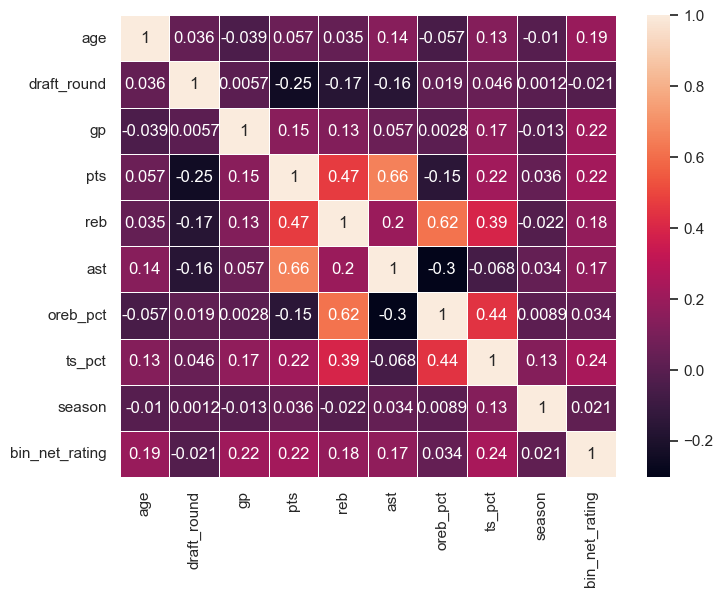

In [93]:
# Graficamos la matriz de correlación de las variables restantes
plt.figure(figsize=(8, 6))
sns.heatmap(nba_extra.corr(), annot = True, linewidths=0.5)

In [94]:
correlation_matrix = nba_extra.corr()
correlation_with_bin_net_rating = correlation_matrix['bin_net_rating']

print(correlation_with_bin_net_rating)

age               0.192748
draft_round      -0.020885
gp                0.216099
pts               0.221585
reb               0.178206
ast               0.166096
oreb_pct          0.034075
ts_pct            0.240810
season            0.020748
bin_net_rating    1.000000
Name: bin_net_rating, dtype: float64


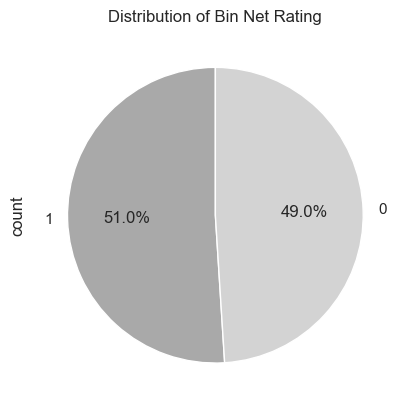

<Figure size 600x400 with 0 Axes>

In [95]:
# Ver visualmente datos desbalanceados
colors = ['lightgray' if round_num != 1 else 'darkgray' for round_num in range(1, 8)]

nba_extra['bin_net_rating'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Distribution of Bin Net Rating')
plt.figure(figsize=(6, 4))
plt.show()


C:\Users\Marc\AppData\Local\Temp\ipykernel_27488\724503120.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='bin_net_rating', y=feature, data=nba_extra, ax=axes[i], palette='husl')
C:\Users\Marc\AppData\Local\Temp\ipykernel_27488\724503120.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='bin_net_rating', y=feature, data=nba_extra, ax=axes[i], palette='husl')
C:\Users\Marc\AppData\Local\Temp\ipykernel_27488\724503120.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='bin_net_rating', y=feature, data=nba_extra, ax=axes[

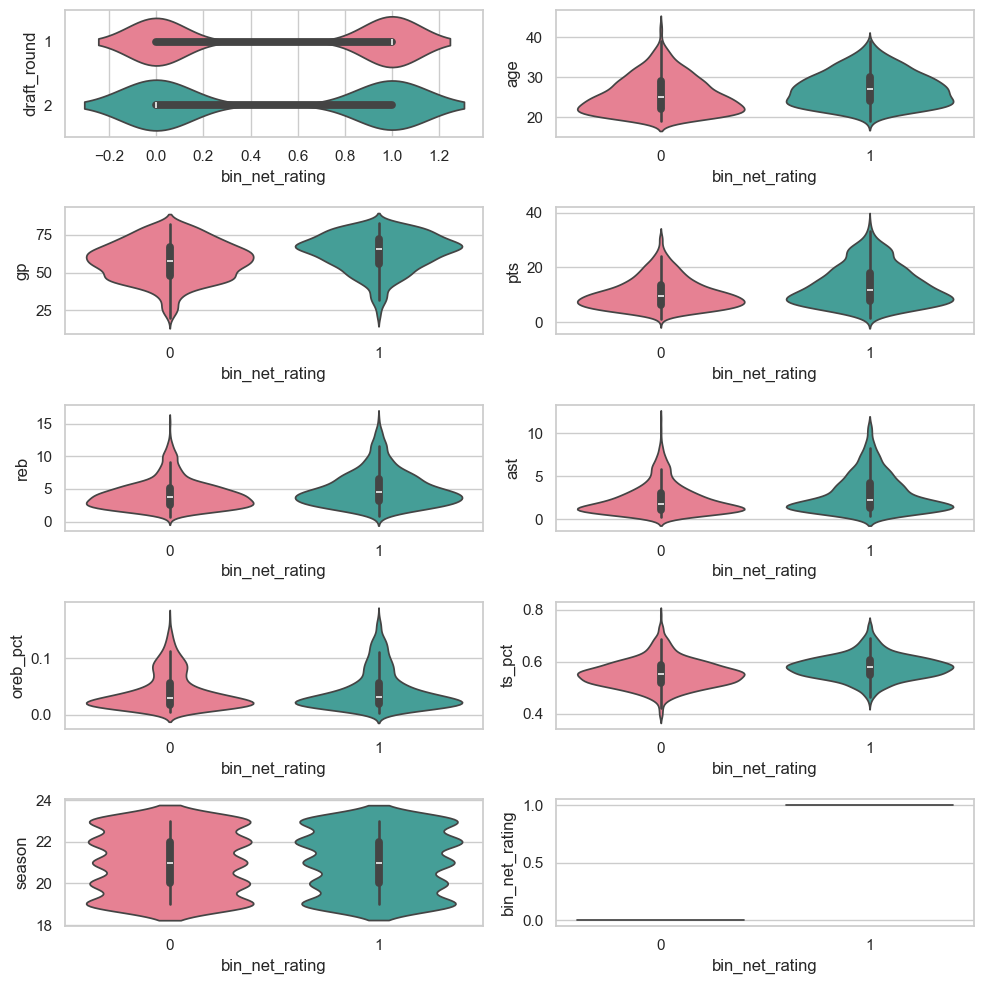

In [96]:
sns.set(style="whitegrid")

selected_features = ['draft_round','age','gp', 'pts','reb','ast','oreb_pct','ts_pct','season','bin_net_rating']

fig, axes = plt.subplots(nrows=len(selected_features) // 2, ncols=2, figsize=(10, 2 * (len(selected_features) // 2)))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.violinplot(x='bin_net_rating', y=feature, data=nba_extra, ax=axes[i], palette='husl')

plt.tight_layout()
plt.show()

<Figure size 1500x1500 with 0 Axes>

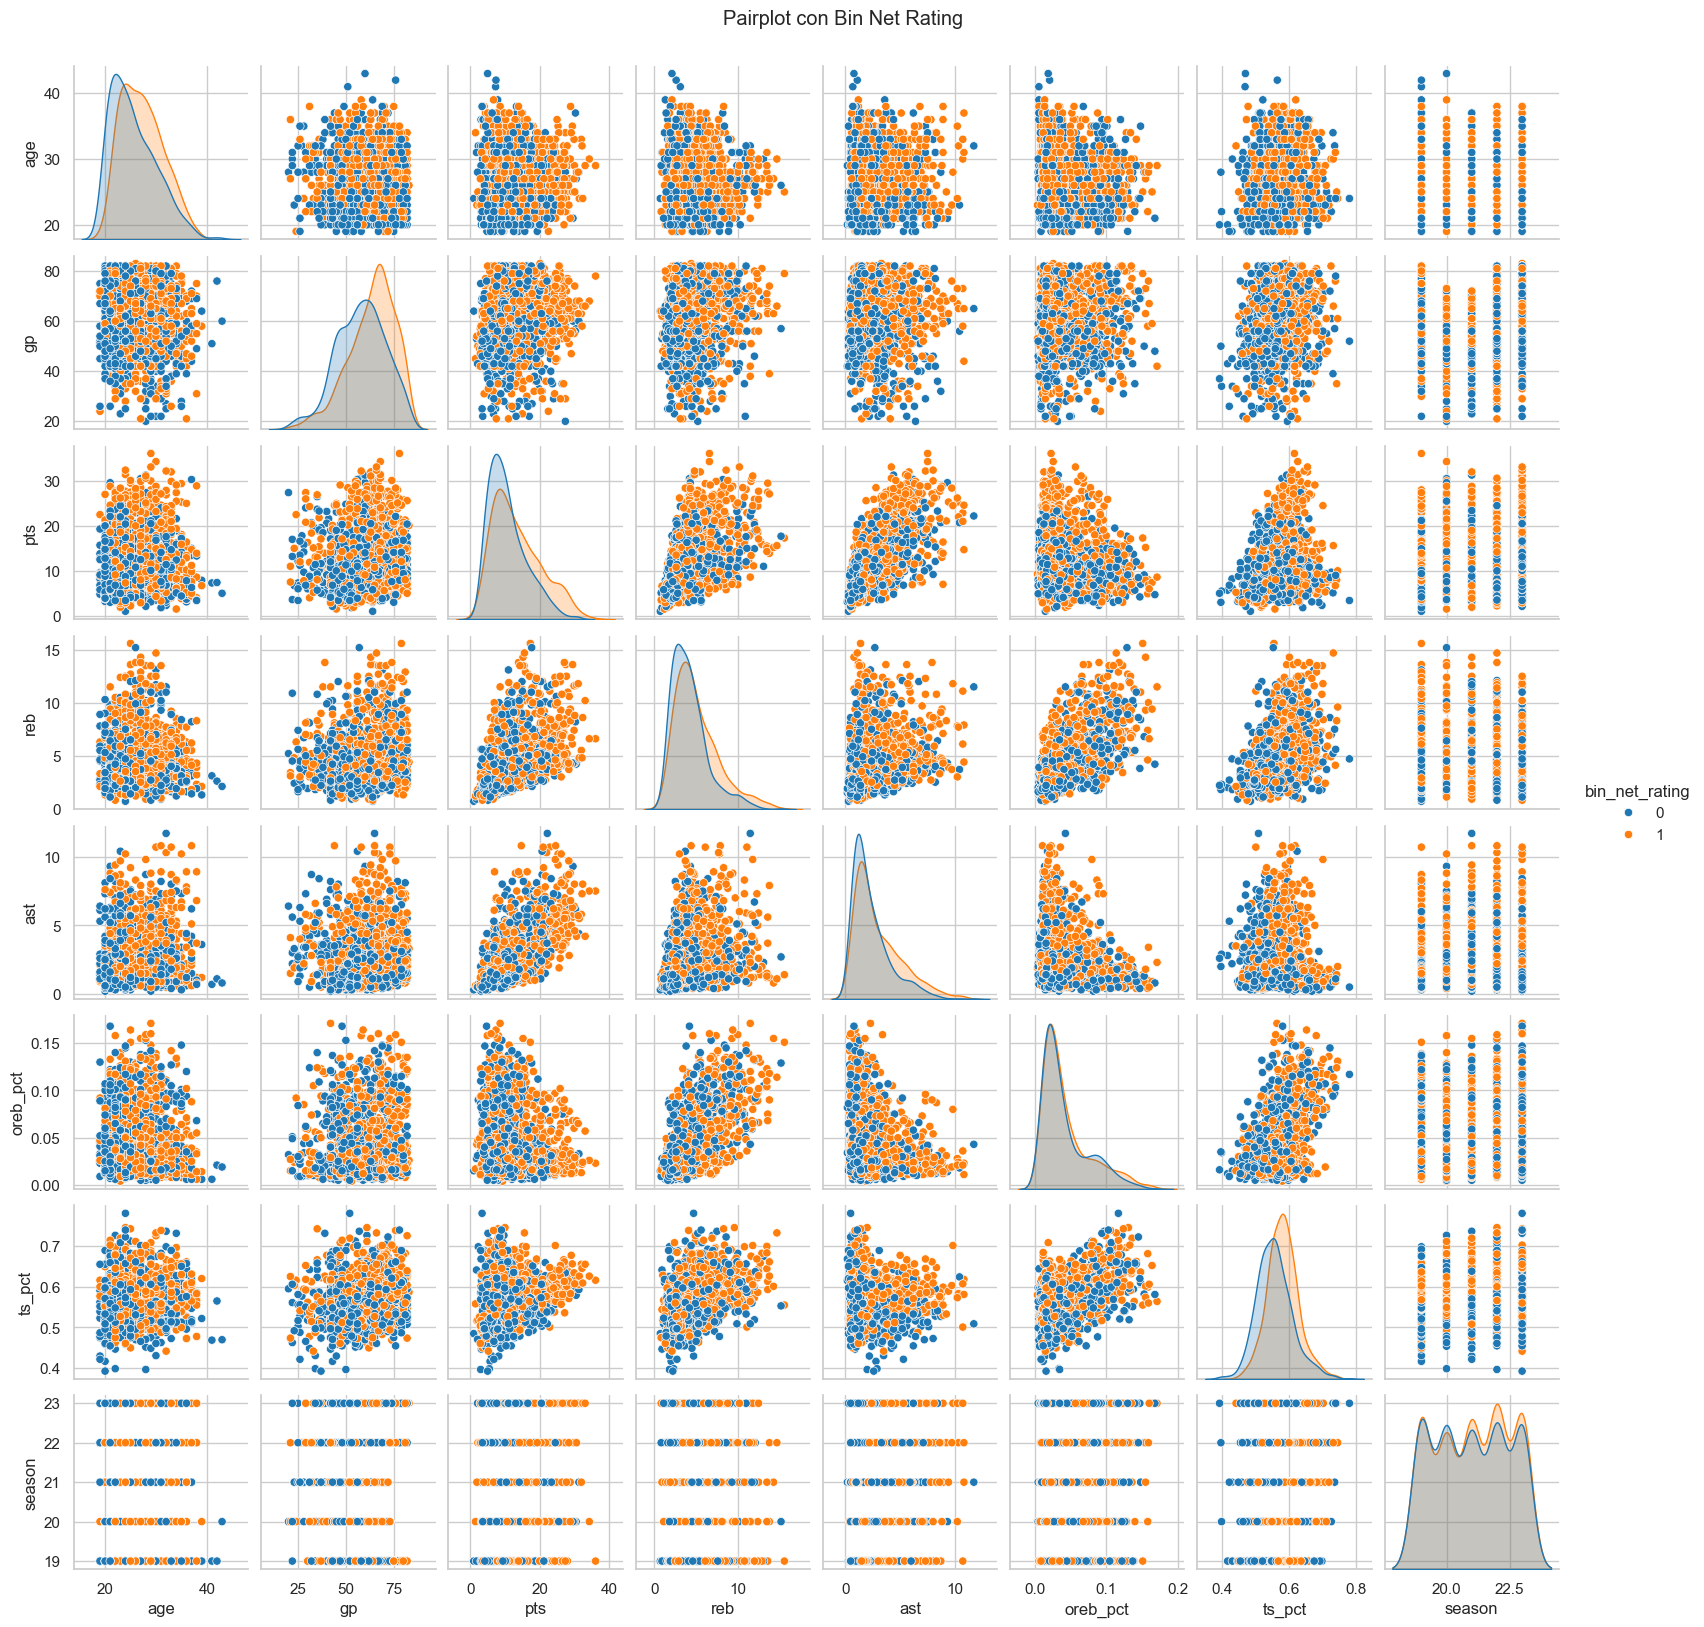

In [97]:
pairplot_data = nba_extra

plt.figure(figsize=(15, 15)) 
sns.pairplot(pairplot_data, height=2, palette='tab10', hue='bin_net_rating')
plt.suptitle('Pairplot con Bin Net Rating', y=1.02) 
plt.show()

Se observa un poco más de separabilidad entre los grupos que en la variable anterior (draft_round) pero sigue estando en la mayoría de los casos todo muy mezcaldo y, por lo tanto, parece difícil que nuestro modelo clasifique estupendamente.

**Modelo sin parametrizar y con todas las variables:**

In [98]:
X_9 = nba_extra.drop(columns=['bin_net_rating'])
y_9 = nba_extra['bin_net_rating']

# Normalizamos los datos
scaler = StandardScaler()
X_9 = scaler.fit_transform(X_9)

In [99]:
# Dividimos el data set entre train y test
X_train_9, X_test_9, y_train_9, y_test_9 = train_test_split(X_9, y_9, test_size=0.2, random_state=33)

# Modelo de Regresión Logística
start_time = time.time()
model = LogisticRegression(random_state=33)
model.fit(X_train_9, y_train_9)

print('Training Data:', len(X_train_9))
print('Testing Data:', len(y_test_9))

Training Data: 1198
Testing Data: 300


Tiempo de ejecución: 0.05498313903808594 segundos
Accuracy: 0.65

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.63      0.64       144
           1       0.66      0.67      0.67       156

    accuracy                           0.65       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.65      0.65      0.65       300



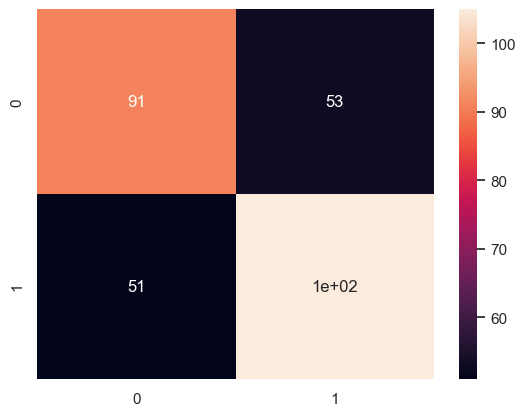

In [100]:
# Hacemos predicciones
y_pred = model.predict(X_test_9)

# Evaluamos el modelo
accuracy = accuracy_score(y_test_9, y_pred)
conf_matrix = confusion_matrix(y_test_9, y_pred)
classification_rep = classification_report(y_test_9, y_pred)

#Tiempo
end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")

# Resultados del modelo
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

El modelo que obtenemos sin practicamente haber tocado el dataset, usando 9 variables que hemos limpiado al principio pero sin más reducción ni selección de variables, nos da unos resultados flojos. Veamos si parametrizando y reduciendo mucho el número de variables somos capaces de mejorar estos números.
- Primero seleccionaremos variables con el PCA
- Luego intentaremos encontrar la mejor combinación de parametros para el modelo

In [101]:
nba_extra_pca = nba_extra.drop(columns = ['bin_net_rating'])

In [102]:
# PCA
pca = PCA(random_state=16)
x_pca_extra = pca.fit_transform(nba_extra_pca)

explained_variance_ratio = pd.Series(pca.explained_variance_ratio_)
print(explained_variance_ratio.round(2))

0    0.70
1    0.18
2    0.08
3    0.02
4    0.01
5    0.01
6    0.00
7    0.00
8    0.00
dtype: float64


In [103]:
loadings = pd.DataFrame(pca.components_.T, columns=[f"Componente {i+1}" for i in range(pca.components_.shape[0])], index=nba_extra_pca.columns)
print(loadings.round(2))

             Componente 1  Componente 2  Componente 3  Componente 4  \
age                  0.01          0.09          0.99          0.01   
draft_round          0.00         -0.02          0.01         -0.01   
gp                  -0.99         -0.10          0.02         -0.01   
pts                 -0.10          0.95         -0.09         -0.14   
reb                 -0.03          0.19         -0.01          0.96   
ast                 -0.01          0.21          0.03         -0.24   
oreb_pct             0.00         -0.00         -0.00          0.01   
ts_pct              -0.00          0.00          0.00          0.01   
season               0.00          0.01         -0.01         -0.05   

             Componente 5  Componente 6  Componente 7  Componente 8  \
age                 -0.01         -0.05         -0.01         -0.00   
draft_round         -0.00         -0.01          1.00         -0.01   
gp                  -0.00          0.00         -0.00         -0.00   
pts  

Los primeros 3 componenetes explican el 96% de la varianza y las variables con más peso en estos componentes son:
- PC1: Variable gp 
- PC2: Variable pts
- PC3: Variable age

Siendo bastante estrictos, podemos reducir nuestro dataset a tan solo 3 variables

In [104]:
nba_extra_postpca = nba_extra[['gp','pts','age','bin_net_rating']]
nba_extra_postpca.head()

gp   pts   age  bin_net_rating
10103  43   5.7  20.0               0
10105  48   5.8  21.0               1
10108  57  12.9  24.0               1
10111  60   7.6  33.0               1
10113  59   4.0  26.0               0

In [105]:
X_10 = nba_extra_postpca.drop(columns=['bin_net_rating'])
y_10 = nba_extra_postpca['bin_net_rating']

# Scaler to avoid the error
scaler = StandardScaler()
X_10 = scaler.fit_transform(X_10)

# Split the dataset into training and testing sets
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_10))
print('Testing Data:', len(y_test_10))

Training Data: 1198
Testing Data: 300


In [106]:
start_time = time.time()
logistic_regression = LogisticRegression(random_state=33)
logistic_regression.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 33,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

En los parametros para elegir he probado con el solucionador liblinear porque funciona bien con 'one versus rest schemes' y con datasets pequeños y con newton-cholesky porque tambien parece funcionar con clasificaciones binarias.


In [107]:
param_grid = {"max_iter": [100, 500, 1000], "C":[2, 3, 4, 5], 'solver':['lbfgs','liblinear','newton-cholesky']}

In [108]:
lr_grid = GridSearchCV(logistic_regression, param_grid, cv=5, scoring= "accuracy")

lr_grid.fit(X_train_10, y_train_10)

print("Mejores parámetros:", lr_grid.best_params_)

Mejores parámetros: {'C': 2, 'max_iter': 100, 'solver': 'lbfgs'}


Tiempo de ejecución: 1.0598313808441162 segundos
Accuracy: 0.6233
Precision: 0.6369
Recall: 0.6410
Specificity: 0.6042

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.60      0.61       144
           1       0.64      0.64      0.64       156

    accuracy                           0.62       300
   macro avg       0.62      0.62      0.62       300
weighted avg       0.62      0.62      0.62       300



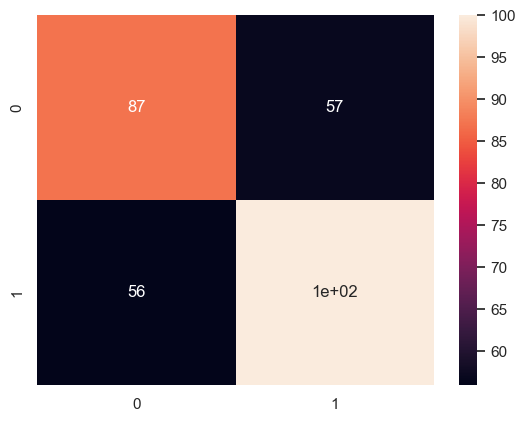

In [109]:
best_lr_model = lr_grid.best_estimator_

y_pred_lr = best_lr_model.predict(X_test_10)

end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")

accuracy = accuracy_score(y_test_10, y_pred_lr)
precision = precision_score(y_test_10, y_pred_lr)
recall = recall_score(y_test_10, y_pred_lr)
tn, fp, fn, tp = confusion_matrix(y_test_10, y_pred_lr).ravel()
specificity = tn / (tn+fp)
conf_matrix = confusion_matrix(y_test_10, y_pred_lr)
classification_rep = classification_report(y_test_10, y_pred_lr)

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Specificity: {:.4f}".format(specificity))
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

Los resultados del modelo son mínimamente inferiores, pasamos a solo acertar en el 62% de los casos. Pero es curioso observar como esto se ve pese a la reducción de hasta 6 variables que hemos podido hacer gracias al PCA. El modelo sigue siendo muy mejorable, pero hemos optimizado los recursos.

In [110]:
nba_extra_pca2 = nba_extra_postpca.drop(columns = ['age'])

In [111]:
X_11 = nba_extra_postpca.drop(columns=['bin_net_rating'])
y_11 = nba_extra_postpca['bin_net_rating']

# Scaler to avoid the error
scaler = StandardScaler()
X_11 = scaler.fit_transform(X_11)

# Split the dataset into training and testing sets
X_train_11, X_test_11, y_train_11, y_test_11 = train_test_split(X_11, y_11, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_11))
print('Testing Data:', len(y_test_11))

Training Data: 1198
Testing Data: 300


In [112]:
param_grid = {"max_iter": [100, 500, 1000], "C":[2, 3, 4, 5], 'solver':['lbfgs','liblinear','newton-cholesky']}

In [113]:
lr_grid = GridSearchCV(logistic_regression, param_grid, cv=5, scoring= "accuracy")

lr_grid.fit(X_train_11, y_train_11)

print("Mejores parámetros:", lr_grid.best_params_)

Mejores parámetros: {'C': 2, 'max_iter': 100, 'solver': 'lbfgs'}


Tiempo de ejecución: 2.2760977745056152 segundos
Accuracy: 0.6233
Precision: 0.6369
Recall: 0.6410
Specificity: 0.6042

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.60      0.61       144
           1       0.64      0.64      0.64       156

    accuracy                           0.62       300
   macro avg       0.62      0.62      0.62       300
weighted avg       0.62      0.62      0.62       300



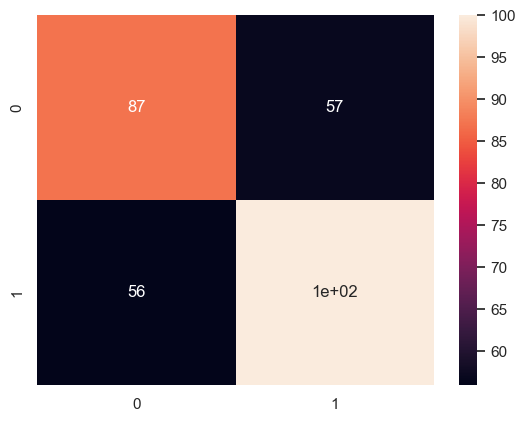

In [114]:
best_lr_model = lr_grid.best_estimator_

y_pred_lr = best_lr_model.predict(X_test_11)

end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")

accuracy = accuracy_score(y_test_11, y_pred_lr)
precision = precision_score(y_test_11, y_pred_lr)
recall = recall_score(y_test_11, y_pred_lr)
tn, fp, fn, tp = confusion_matrix(y_test_11, y_pred_lr).ravel()
specificity = tn / (tn+fp)
conf_matrix = confusion_matrix(y_test_11, y_pred_lr)
classification_rep = classification_report(y_test_11, y_pred_lr)

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Specificity: {:.4f}".format(specificity))
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

De hecho, la calidad de un modelo con tan solo 2 (!) variables es prácticamente la misma que al inicio. En este caso he eliminado la variable age, que era la que daba más información del componente 3, aquel con un impacto de solo un 8% en la varianza total de la variable objetivo.

# Multiclase - Variable Net Rating

Vamos a crear 4 clases distintas con la varialbe Net Rating para intentar usar algun otro algoritmo que nos ayude.

<function matplotlib.pyplot.show(close=None, block=None)>

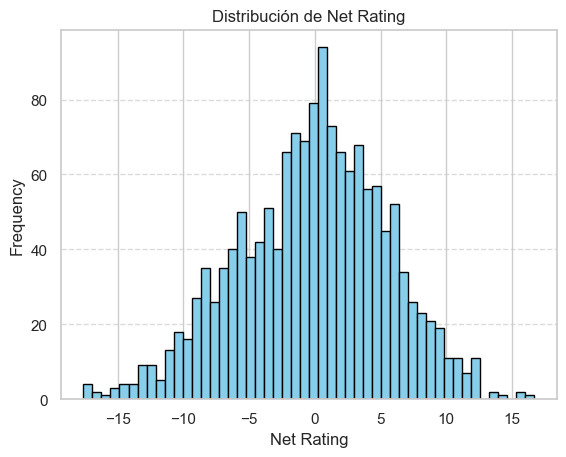

In [115]:
# Distribución partidos jugados

nba_recent['net_rating'].plot.hist(bins=50,edgecolor = 'black', color= 'skyblue')

plt.title('Distribución de Net Rating')
plt.xlabel('Net Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha = 0.7)

plt.show

In [116]:
# Crear la variable con cuatro grupos
nba_recent['four_netrating'] = pd.cut(nba_recent['net_rating'],
                                            bins=[float('-inf'), -5, 0, 5, float('inf')],
                                            labels=[0, 1, 2, 3],
                                            include_lowest=True)

nba_extra2 = nba_recent.drop(columns = ['bin_net_rating','net_rating'])
nba_extra2.head()

age draft_round  gp   pts  reb  ast  oreb_pct  ts_pct  season  \
10103  20.0           1  43   5.7  2.0  2.8     0.012   0.417      19   
10105  21.0           1  48   5.8  2.2  1.1     0.023   0.528      19   
10108  24.0           1  57  12.9  2.8  2.2     0.024   0.526      19   
10111  33.0           1  60   7.6  2.5  2.3     0.028   0.554      19   
10113  26.0           2  59   4.0  1.5  0.6     0.022   0.613      19   

      four_netrating  
10103              0  
10105              2  
10108              3  
10111              3  
10113              0

In [117]:
df = pd.DataFrame(nba_extra2)

# Save the dataset as a CSV file
df.to_csv('nba_extra2.csv', index=False)

print("Dataset saved as 'nba_extra2.csv'")

Dataset saved as 'nba_extra2.csv'


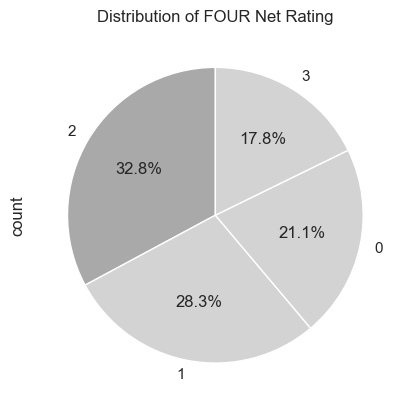

<Figure size 600x400 with 0 Axes>

In [118]:
# Ver visualmente datos desbalanceados
colors = ['lightgray' if round_num != 1 else 'darkgray' for round_num in range(1, 8)]

nba_extra2['four_netrating'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Distribution of FOUR Net Rating')
plt.figure(figsize=(6, 4))
plt.show()


<Figure size 1500x1500 with 0 Axes>

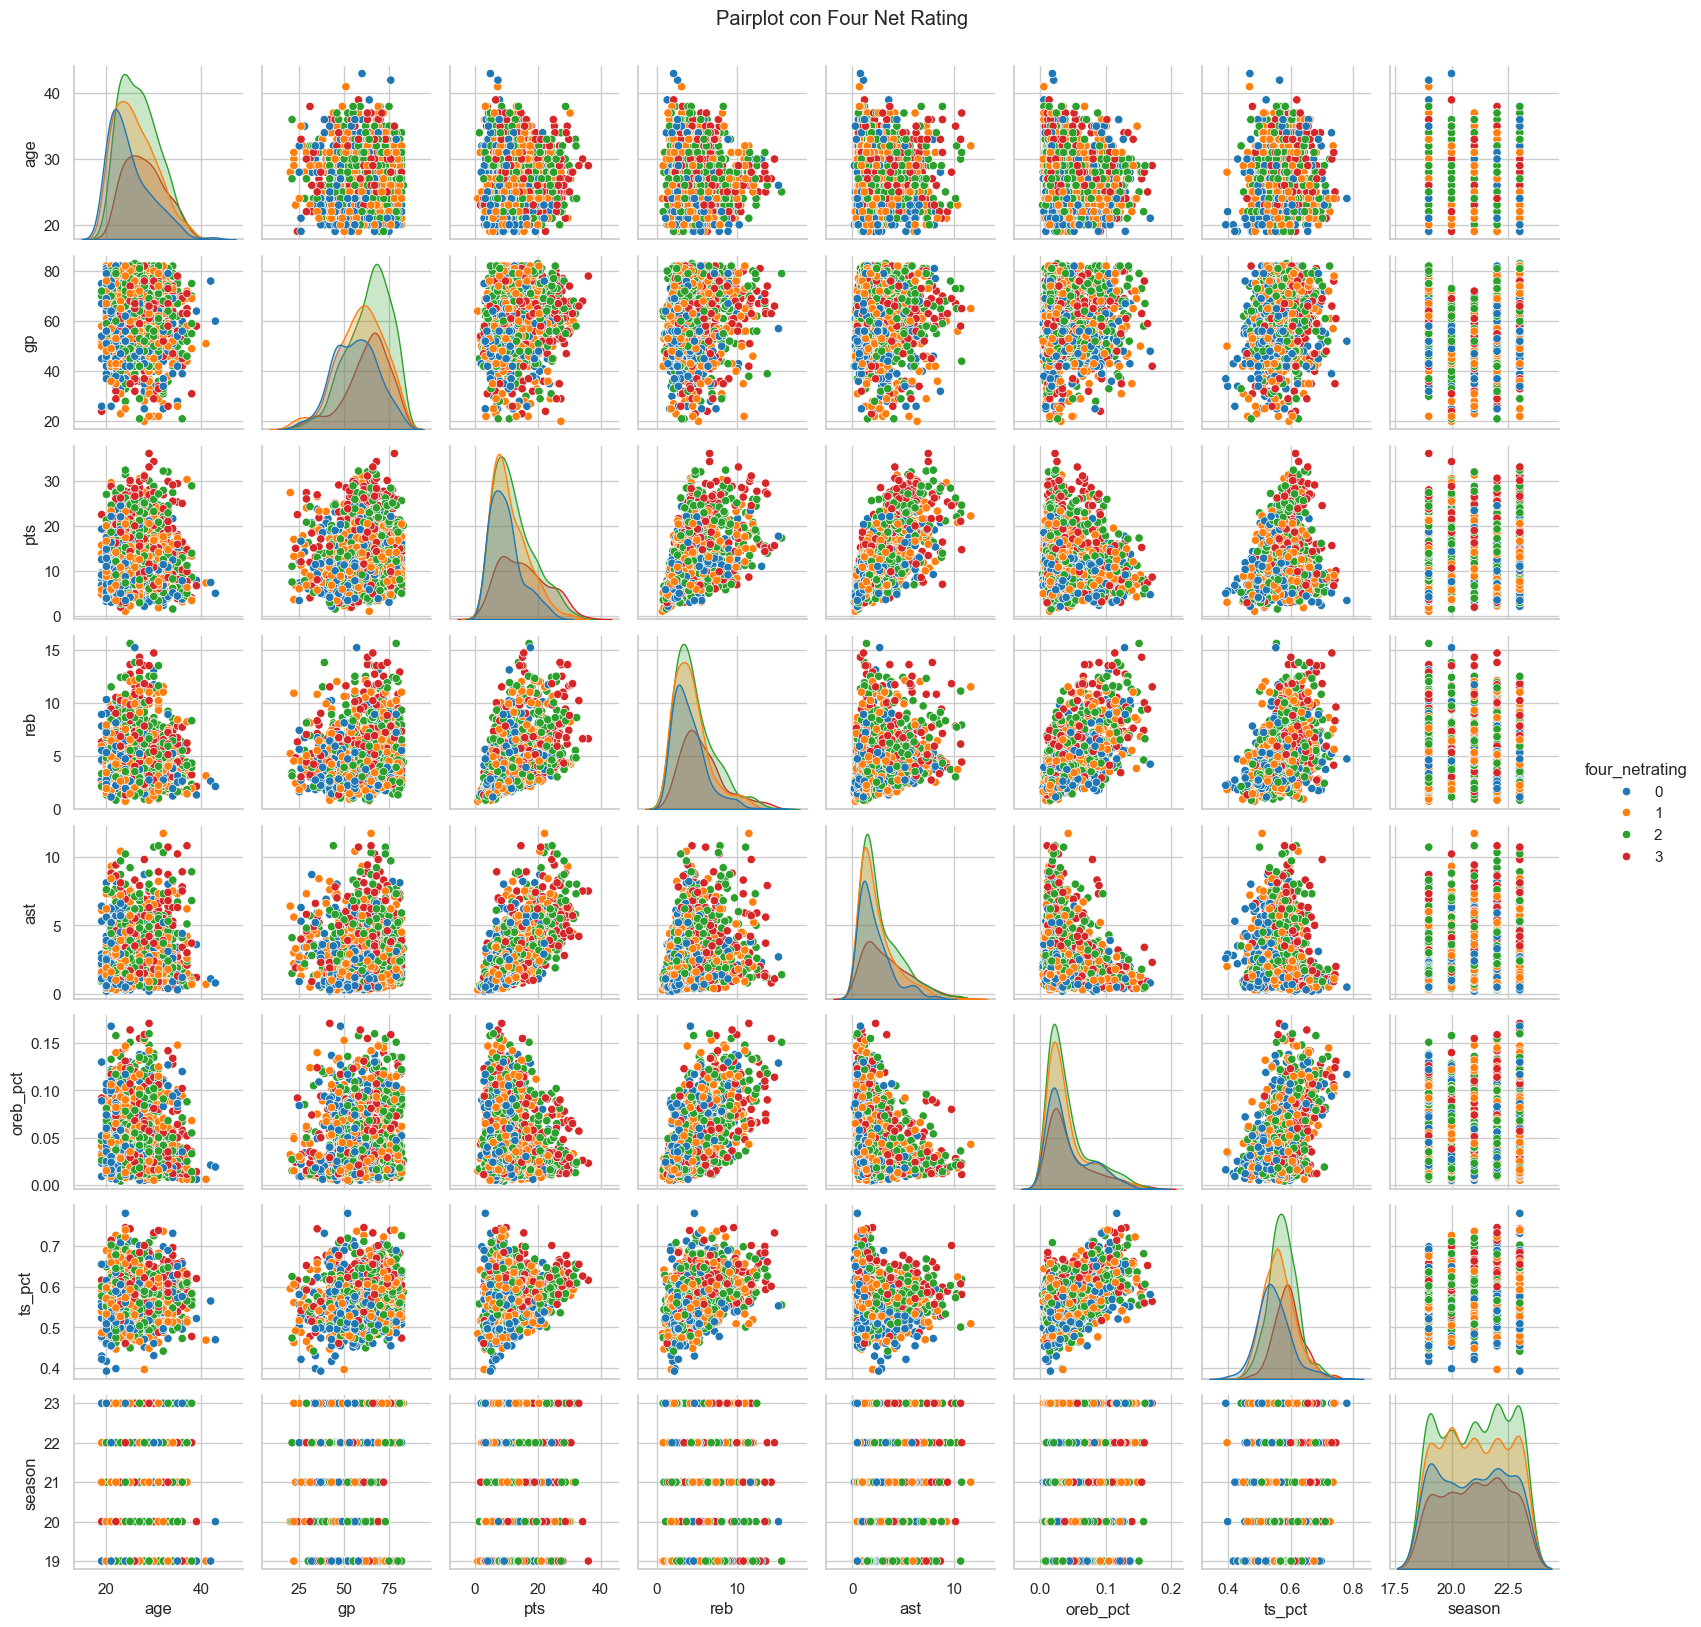

In [119]:
pairplot_data = nba_extra2

plt.figure(figsize=(15, 15)) 
sns.pairplot(pairplot_data, height=2, palette='tab10', hue='four_netrating')
plt.suptitle('Pairplot con Four Net Rating', y=1.02) 
plt.show()

Una vez hemos creado la variable y gráficado para hacernos una idea, la verdad es que en este caso no parece haber a simple vista una clasificación senzilla. Pero vamos a intentar un primer modelo, usando Grid Search y dando una matriz de opciones para intentar obtener el mejor modelo posible.

In [120]:
X_11 = nba_extra2.drop(columns=['four_netrating'])
y_11 = nba_extra2['four_netrating']

# Scaler to avoid the error
scaler = StandardScaler()
X_11 = scaler.fit_transform(X_11)

# Split the dataset into training and testing sets
X_train_11, X_test_11, y_train_11, y_test_11 = train_test_split(X_11, y_11, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_11))
print('Testing Data:', len(y_test_11))

Training Data: 1198
Testing Data: 300


In [121]:
start_time = time.time()
logistic_regression = DecisionTreeClassifier(random_state=33)
logistic_regression.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 33,
 'splitter': 'best'}

In [122]:
model_params={
    'ccp_alpha':[10,20,30,40,50],
    'criterion':['gini','entropy'],
    'max_leaf_nodes':[100,200,500,1000],
    'min_samples_split':[4,6,8,10]
}

In [123]:
model_extra = DecisionTreeClassifier(random_state=33)
gscv = GridSearchCV(model_extra, model_params, cv = 3)
model_gs = gscv.fit(X_train_11, y_train_11)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))

Best: 0.333056 using {'ccp_alpha': 10, 'criterion': 'gini', 'max_leaf_nodes': 100, 'min_samples_split': 4}


Accuracy: 0.31

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.00      0.00      0.00        89
           2       0.31      1.00      0.47        93
           3       0.00      0.00      0.00        60

    accuracy                           0.31       300
   macro avg       0.08      0.25      0.12       300
weighted avg       0.10      0.31      0.15       300



c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

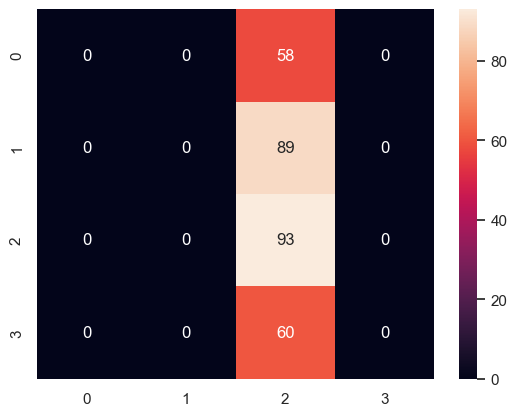

In [124]:
model_extra = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=4, criterion='gini',ccp_alpha=10)
model_extra.fit(X_train_11,y_train_11)
prediction = model_extra.predict(X_test_11)

# Evaluate the model
accuracy = accuracy_score(y_test_11, prediction)
conf_matrix = confusion_matrix(y_test_11, prediction)
classification_rep = classification_report(y_test_11, prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

La realidad es que el modelo es malísimo, no solo por los resultados globales, sino porque al graficar la matriz de confusión nos damos cuenta de que el modelo simplemente predice que todos los jugadores son de la clase 2 y no nos soluciona nada. He probado también el modelo sin parametrizar (a continuación) y sigue siendo muy malo, incluso peor según los principales estadísticos de precisión, pero ahora al menos intenta predecir distintas clases (aunque sin éxito).

Accuracy: 0.25

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.29      0.28        58
           1       0.22      0.22      0.22        89
           2       0.26      0.27      0.27        93
           3       0.23      0.20      0.21        60

    accuracy                           0.25       300
   macro avg       0.25      0.25      0.25       300
weighted avg       0.25      0.25      0.25       300



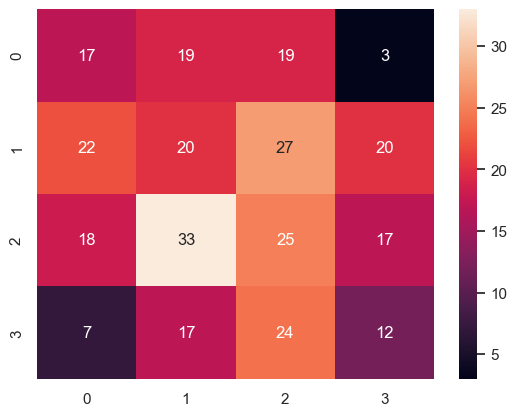

In [125]:
# Modelo sin parametrizar
model_extra = DecisionTreeClassifier(random_state=33)
model_extra.fit(X_train_11,y_train_11)
prediction = model_extra.predict(X_test_11)

# Evaluate the model
accuracy = accuracy_score(y_test_11, prediction)
conf_matrix = confusion_matrix(y_test_11, prediction)
classification_rep = classification_report(y_test_11, prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

Vamos a intentar solucionar esto eliminando variables con un PCA y probando si la calidad del modelo mejora.

In [126]:
nba_extra2_pca = nba_extra2.drop(columns = ['four_netrating'])
nba_extra2_pca.head()

age draft_round  gp   pts  reb  ast  oreb_pct  ts_pct  season
10103  20.0           1  43   5.7  2.0  2.8     0.012   0.417      19
10105  21.0           1  48   5.8  2.2  1.1     0.023   0.528      19
10108  24.0           1  57  12.9  2.8  2.2     0.024   0.526      19
10111  33.0           1  60   7.6  2.5  2.3     0.028   0.554      19
10113  26.0           2  59   4.0  1.5  0.6     0.022   0.613      19

In [127]:
# PCA
pca = PCA(random_state=33)
x_pca_extra2 = pca.fit_transform(nba_extra2_pca)

explained_variance_ratio = pd.Series(pca.explained_variance_ratio_)
print(explained_variance_ratio.round(2))

0    0.70
1    0.18
2    0.08
3    0.02
4    0.01
5    0.01
6    0.00
7    0.00
8    0.00
dtype: float64


In [128]:
loadings = pd.DataFrame(pca.components_.T, columns=[f"Componente {i+1}" for i in range(pca.components_.shape[0])], index=nba_extra2_pca.columns)
print(loadings.round(2))

             Componente 1  Componente 2  Componente 3  Componente 4  \
age                  0.01          0.09          0.99          0.01   
draft_round          0.00         -0.02          0.01         -0.01   
gp                  -0.99         -0.10          0.02         -0.01   
pts                 -0.10          0.95         -0.09         -0.14   
reb                 -0.03          0.19         -0.01          0.96   
ast                 -0.01          0.21          0.03         -0.24   
oreb_pct             0.00         -0.00         -0.00          0.01   
ts_pct              -0.00          0.00          0.00          0.01   
season               0.00          0.01         -0.01         -0.05   

             Componente 5  Componente 6  Componente 7  Componente 8  \
age                 -0.01         -0.05         -0.01         -0.00   
draft_round         -0.00         -0.01          1.00         -0.01   
gp                  -0.00          0.00         -0.00         -0.00   
pts  

Los resultados son los mismos que en caso de la variable binaria de net rating, tiene todo el sentido del mundo porque las variables son practicamente la misma (seguramente ha sido una tonteria intentar esto pero quería asegurarme).

In [129]:
nba_extra_postpca2 = nba_extra2[['pts','pts','age','four_netrating']]
nba_extra_postpca2.head()

pts   pts   age four_netrating
10103   5.7   5.7  20.0              0
10105   5.8   5.8  21.0              2
10108  12.9  12.9  24.0              3
10111   7.6   7.6  33.0              3
10113   4.0   4.0  26.0              0

In [130]:
X_12 = nba_extra_postpca2.drop(columns=['four_netrating'])
y_12 = nba_extra_postpca2['four_netrating']

# Scaler to avoid the error
scaler = StandardScaler()
X_12 = scaler.fit_transform(X_12)

# Split the dataset into training and testing sets
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(X_12, y_12, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_12))
print('Testing Data:', len(y_test_12))

Training Data: 1198
Testing Data: 300


In [131]:
start_time = time.time()
logistic_regression = DecisionTreeClassifier(random_state=33)
logistic_regression.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 33,
 'splitter': 'best'}

In [132]:
model_params={
    'ccp_alpha':[10,20,30,40,50],
    'criterion':['gini','entropy'],
    'max_leaf_nodes':[100,200,500,1000],
    'min_samples_split':[4,6,8,10]
}

He probado múltiples combinaciones y el modelo siempre tiende a escoger el número de nodos y cortes más bajos posibles, así que he decidio dejarlo así ya que los resultados no parecen cambiar en exceso.

In [133]:
ultimo = DecisionTreeClassifier(random_state=33)
gscv = GridSearchCV(ultimo, model_params, cv = 3)
model_gs = gscv.fit(X_train_12, y_train_12)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))

Best: 0.333056 using {'ccp_alpha': 10, 'criterion': 'gini', 'max_leaf_nodes': 100, 'min_samples_split': 4}


Accuracy: 0.31

Confusion Matrix:


c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.00      0.00      0.00        89
           2       0.31      1.00      0.47        93
           3       0.00      0.00      0.00        60

    accuracy                           0.31       300
   macro avg       0.08      0.25      0.12       300
weighted avg       0.10      0.31      0.15       300



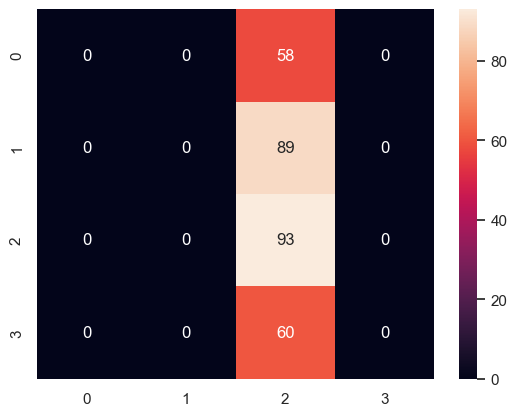

In [134]:
model_extra = DecisionTreeClassifier(max_leaf_nodes=100, min_samples_split=4, criterion='gini',ccp_alpha=10)
model_extra.fit(X_train_11,y_train_11)
prediction = model_extra.predict(X_test_11)

# Evaluate the model
accuracy = accuracy_score(y_test_11, prediction)
conf_matrix = confusion_matrix(y_test_11, prediction)
classification_rep = classification_report(y_test_11, prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.25

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.26      0.22        58
           1       0.21      0.17      0.19        89
           2       0.34      0.37      0.35        93
           3       0.19      0.17      0.18        60

    accuracy                           0.25       300
   macro avg       0.23      0.24      0.24       300
weighted avg       0.24      0.25      0.24       300



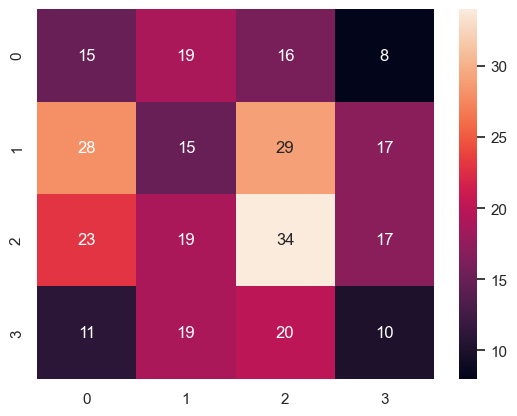

In [135]:
# Modelo sin parametrizar
ahora_si = DecisionTreeClassifier(random_state=33)
ahora_si.fit(X_train_12,y_train_12)
prediction = ahora_si.predict(X_test_12)

# Evaluate the model
accuracy = accuracy_score(y_test_12, prediction)
conf_matrix = confusion_matrix(y_test_12, prediction)
classification_rep = classification_report(y_test_12, prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

¡Los resultados siguen siendo igual de malos! La realidad es que no se explicar que sucede con estos últimos modelo, por lo que hemos comentado en clase parecía ser que una variable podia estar fallando. He eliminado muchísimas de ellas y los resultados siguen siendo muy parecidos.

La verdad es que me he quedado un poco frustrado con esto último, puede ser que simplemente la variable fuera como dices tu "una castaña" pero no estoy entendiendo porque es tan (tan) mala cuando la hago multiclase y porque en caso de ser binaria no acaba de ser buena pero tampoco es así de horrible.

Esta última parte la estoy entregando porque quería intentar solucionar esto y sinceramente, quería intentar tener algun modelo un poqutio mejor :), haciendo esto, he repasado y he hecho un par de correciones a la primera versión. Dicho esto, no espero que influya ni positivamente ni negativamente en la nota, quería más feedback y ahora ya quiero entender lo que sucede aquí y porque salen estos resultados tan "raros".

Como último apunte, he decidio probar estas cosas hoy en clase porque ha sido mi forma de "tomar apuntes" llevo ya semanas tomando muchos apuntes en la libreta y luego cuando me enfrento a los casos prácticos no siempre me han sido útiles, es por eso que hoy quería probar de aplicarlos conforme los ibas explicando para ir haciendome una idea de como reaccionaban los algoritmos a según que modificaciones y de paso, tener guardado lo que ibas diciendo un documento que he creado.